In [17]:
from utils.Preprocessing import Preprocessing
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.stats import zscore
from networks.Autoencoder import Autoencoder
from utils.metrics import compute_fc_matrix_regular

In [18]:
# Set font to Times New Roman for all text elements
plt.rcParams['font.family'] = 'Times New Roman'
# Set font size
plt.rcParams.update({'font.size': 16})
# Set resolution of plots
plt.rcParams['figure.dpi'] = 300

In [19]:
preprocessor = Preprocessing()
# Load the data.
mat_data = loadmat('./data/laufs_sleep.mat')
assert mat_data['TS_N1'].shape == mat_data['TS_N2'].shape == mat_data['TS_N3'].shape == mat_data['TS_W'].shape

n1_data = mat_data['TS_N1'][0][1:]
n2_data = mat_data['TS_N2'][0][1:]
n3_data = mat_data['TS_N3'][0][1:]
wake_data = mat_data['TS_W'][0][1:]

n1_data_shortened, _ = preprocessor.shorten_data(n1_data, final_length=200)
n2_data_shortened, _ = preprocessor.shorten_data(n2_data, final_length=200)
n3_data_shortened, _ = preprocessor.shorten_data(n3_data, final_length=200)
wake_data_shortened, _ = preprocessor.shorten_data(wake_data, final_length=200)

concatenated_data = np.concatenate([wake_data_shortened, n1_data_shortened, n2_data_shortened, n3_data_shortened])
concatenated_data = zscore(concatenated_data)

In [20]:
concatenated_data = concatenated_data.reshape(-1, 80)

In [21]:
concatenated_data.shape

(11600, 80)

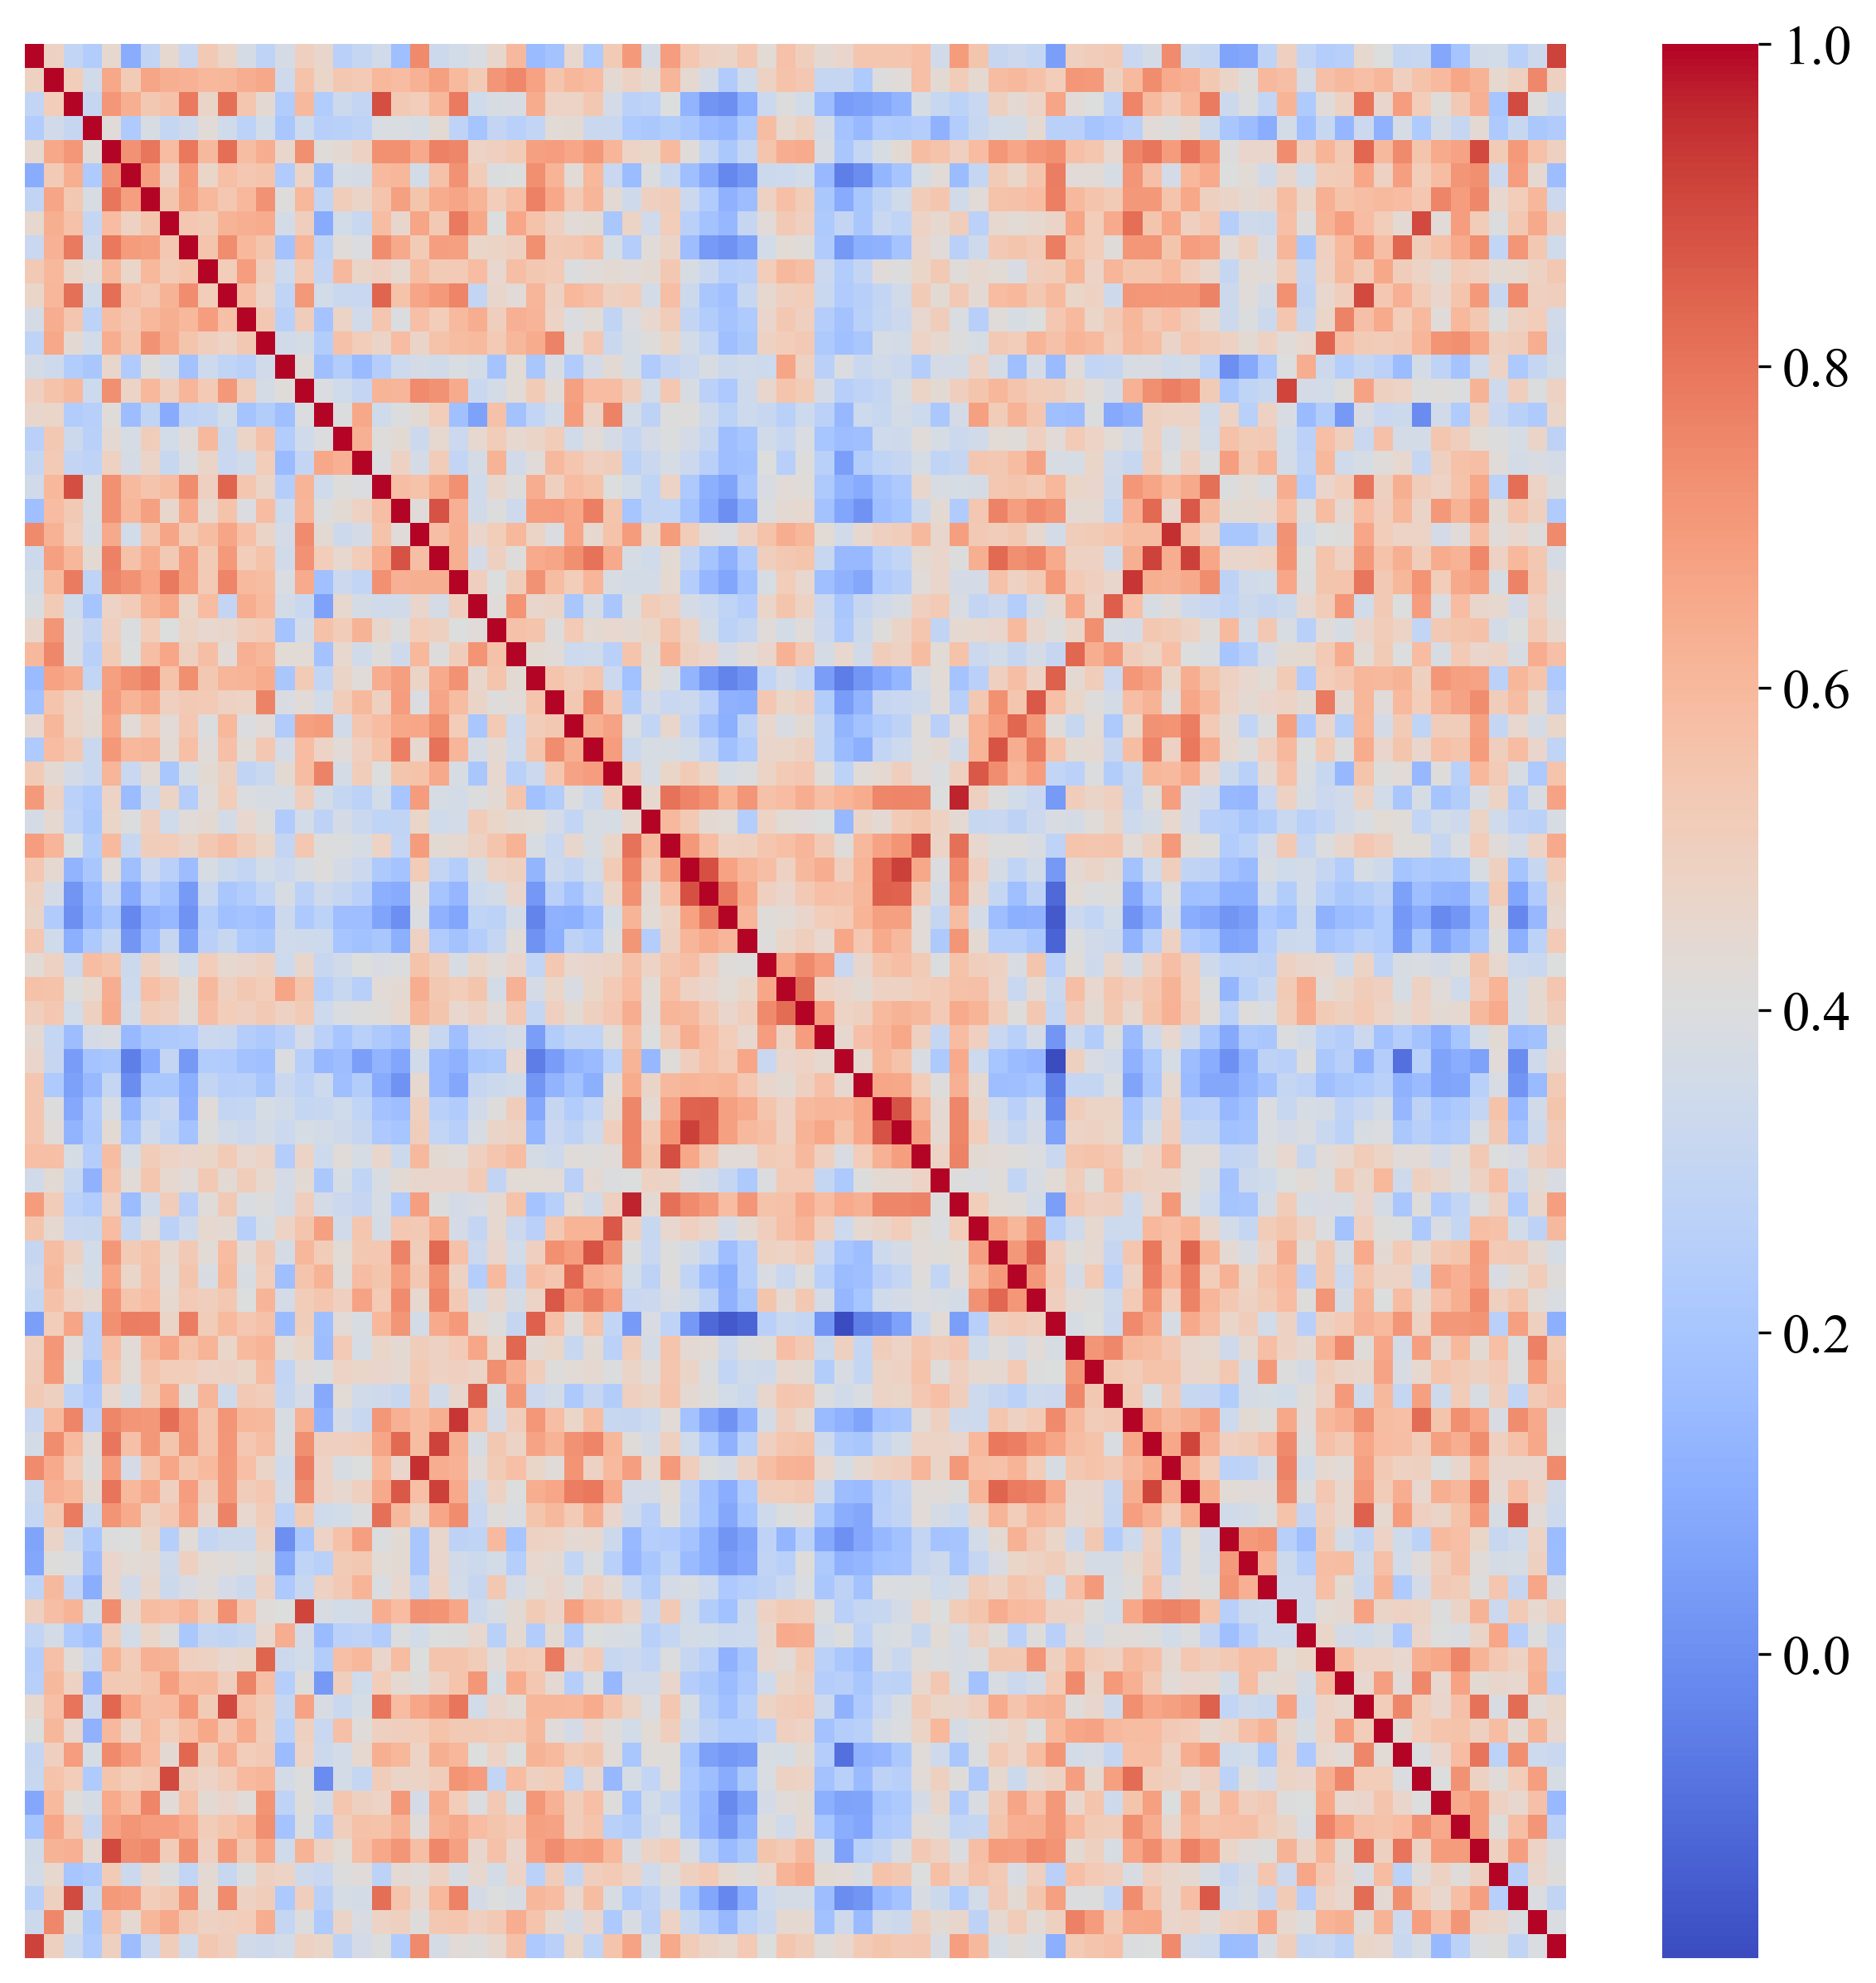

In [22]:
# plot the average correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(np.corrcoef(wake_data[-1]), xticklabels=False, yticklabels=False, cmap='coolwarm')
plt.show()

In [23]:
# concatenated data is now a numpy array with shape (11600, 80)
# we can now convert it to a torch tensor
data = torch.tensor(concatenated_data, dtype=torch.float32)

num_time_points = 200
num_brain_nodes = 80
num_participants = concatenated_data.shape[0] // num_time_points

In [24]:
# reshape data to (num_participants, num_brain_nodes, num_time_points)
data = data.reshape(num_participants, num_brain_nodes, num_time_points)

In [25]:
means = []
stds = []

# Check the mean and standard deviation of the reshaped data for each participant to ensure normalization
for i in range(num_participants):
    mean = torch.mean(data[i])
    std = torch.std(data[i])
    print(f"Participant {i+1} - Mean: {mean.item()}, Std Dev: {std.item()}")

    means.append(mean.item())
    stds.append(std.item())

# Initialize tensor to store correlation matrices
correlation_matrices = torch.empty((num_participants, num_brain_nodes, num_brain_nodes))

# Calculate correlation matrix for each participant
for i in range(num_participants):
    participant_data = data[i]
    # Check the variance of participant data to ensure sufficient variability
    variance = torch.var(participant_data, dim=0)
    print(f"Participant {i+1} - Variance: {variance}")
    
    # Ensure participant_data is a PyTorch tensor
    participant_data_tensor = torch.tensor(participant_data)
    correlation_matrix = torch.corrcoef(participant_data_tensor)
    correlation_matrices[i] = torch.tensor(correlation_matrix)

# Compute the average correlation matrix across participants
average_correlation_matrix = torch.mean(correlation_matrices, dim=0)

Participant 1 - Mean: -0.4354412257671356, Std Dev: 1.4553560018539429
Participant 2 - Mean: 0.10913707315921783, Std Dev: 0.9542997479438782
Participant 3 - Mean: 0.25010305643081665, Std Dev: 0.6859701871871948
Participant 4 - Mean: 0.08353075385093689, Std Dev: 0.9027634263038635
Participant 5 - Mean: 0.02104942314326763, Std Dev: 0.811040997505188
Participant 6 - Mean: -0.04907182976603508, Std Dev: 1.4621398448944092
Participant 7 - Mean: -0.04495697841048241, Std Dev: 1.1362847089767456
Participant 8 - Mean: 0.1479661911725998, Std Dev: 0.6101983785629272
Participant 9 - Mean: -0.03895651549100876, Std Dev: 0.6967600584030151
Participant 10 - Mean: -0.08431980013847351, Std Dev: 0.8286455273628235
Participant 11 - Mean: -0.0848323330283165, Std Dev: 1.1115211248397827
Participant 12 - Mean: -0.09257543832063675, Std Dev: 1.0373705625534058
Participant 13 - Mean: -0.008886953815817833, Std Dev: 0.8267754912376404
Participant 14 - Mean: -0.016966164112091064, Std Dev: 0.80742669105

/var/folders/g_/2zpqj2h15j734d8xg44xmq040000gn/T/ipykernel_7464/3724418487.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  participant_data_tensor = torch.tensor(participant_data)
/var/folders/g_/2zpqj2h15j734d8xg44xmq040000gn/T/ipykernel_7464/3724418487.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correlation_matrices[i] = torch.tensor(correlation_matrix)


In [26]:
assert not torch.isnan(correlation_matrices).any(), "Correlation matrices contain NaN values."

In [27]:
correlation_matrices[0].shape

torch.Size([80, 80])

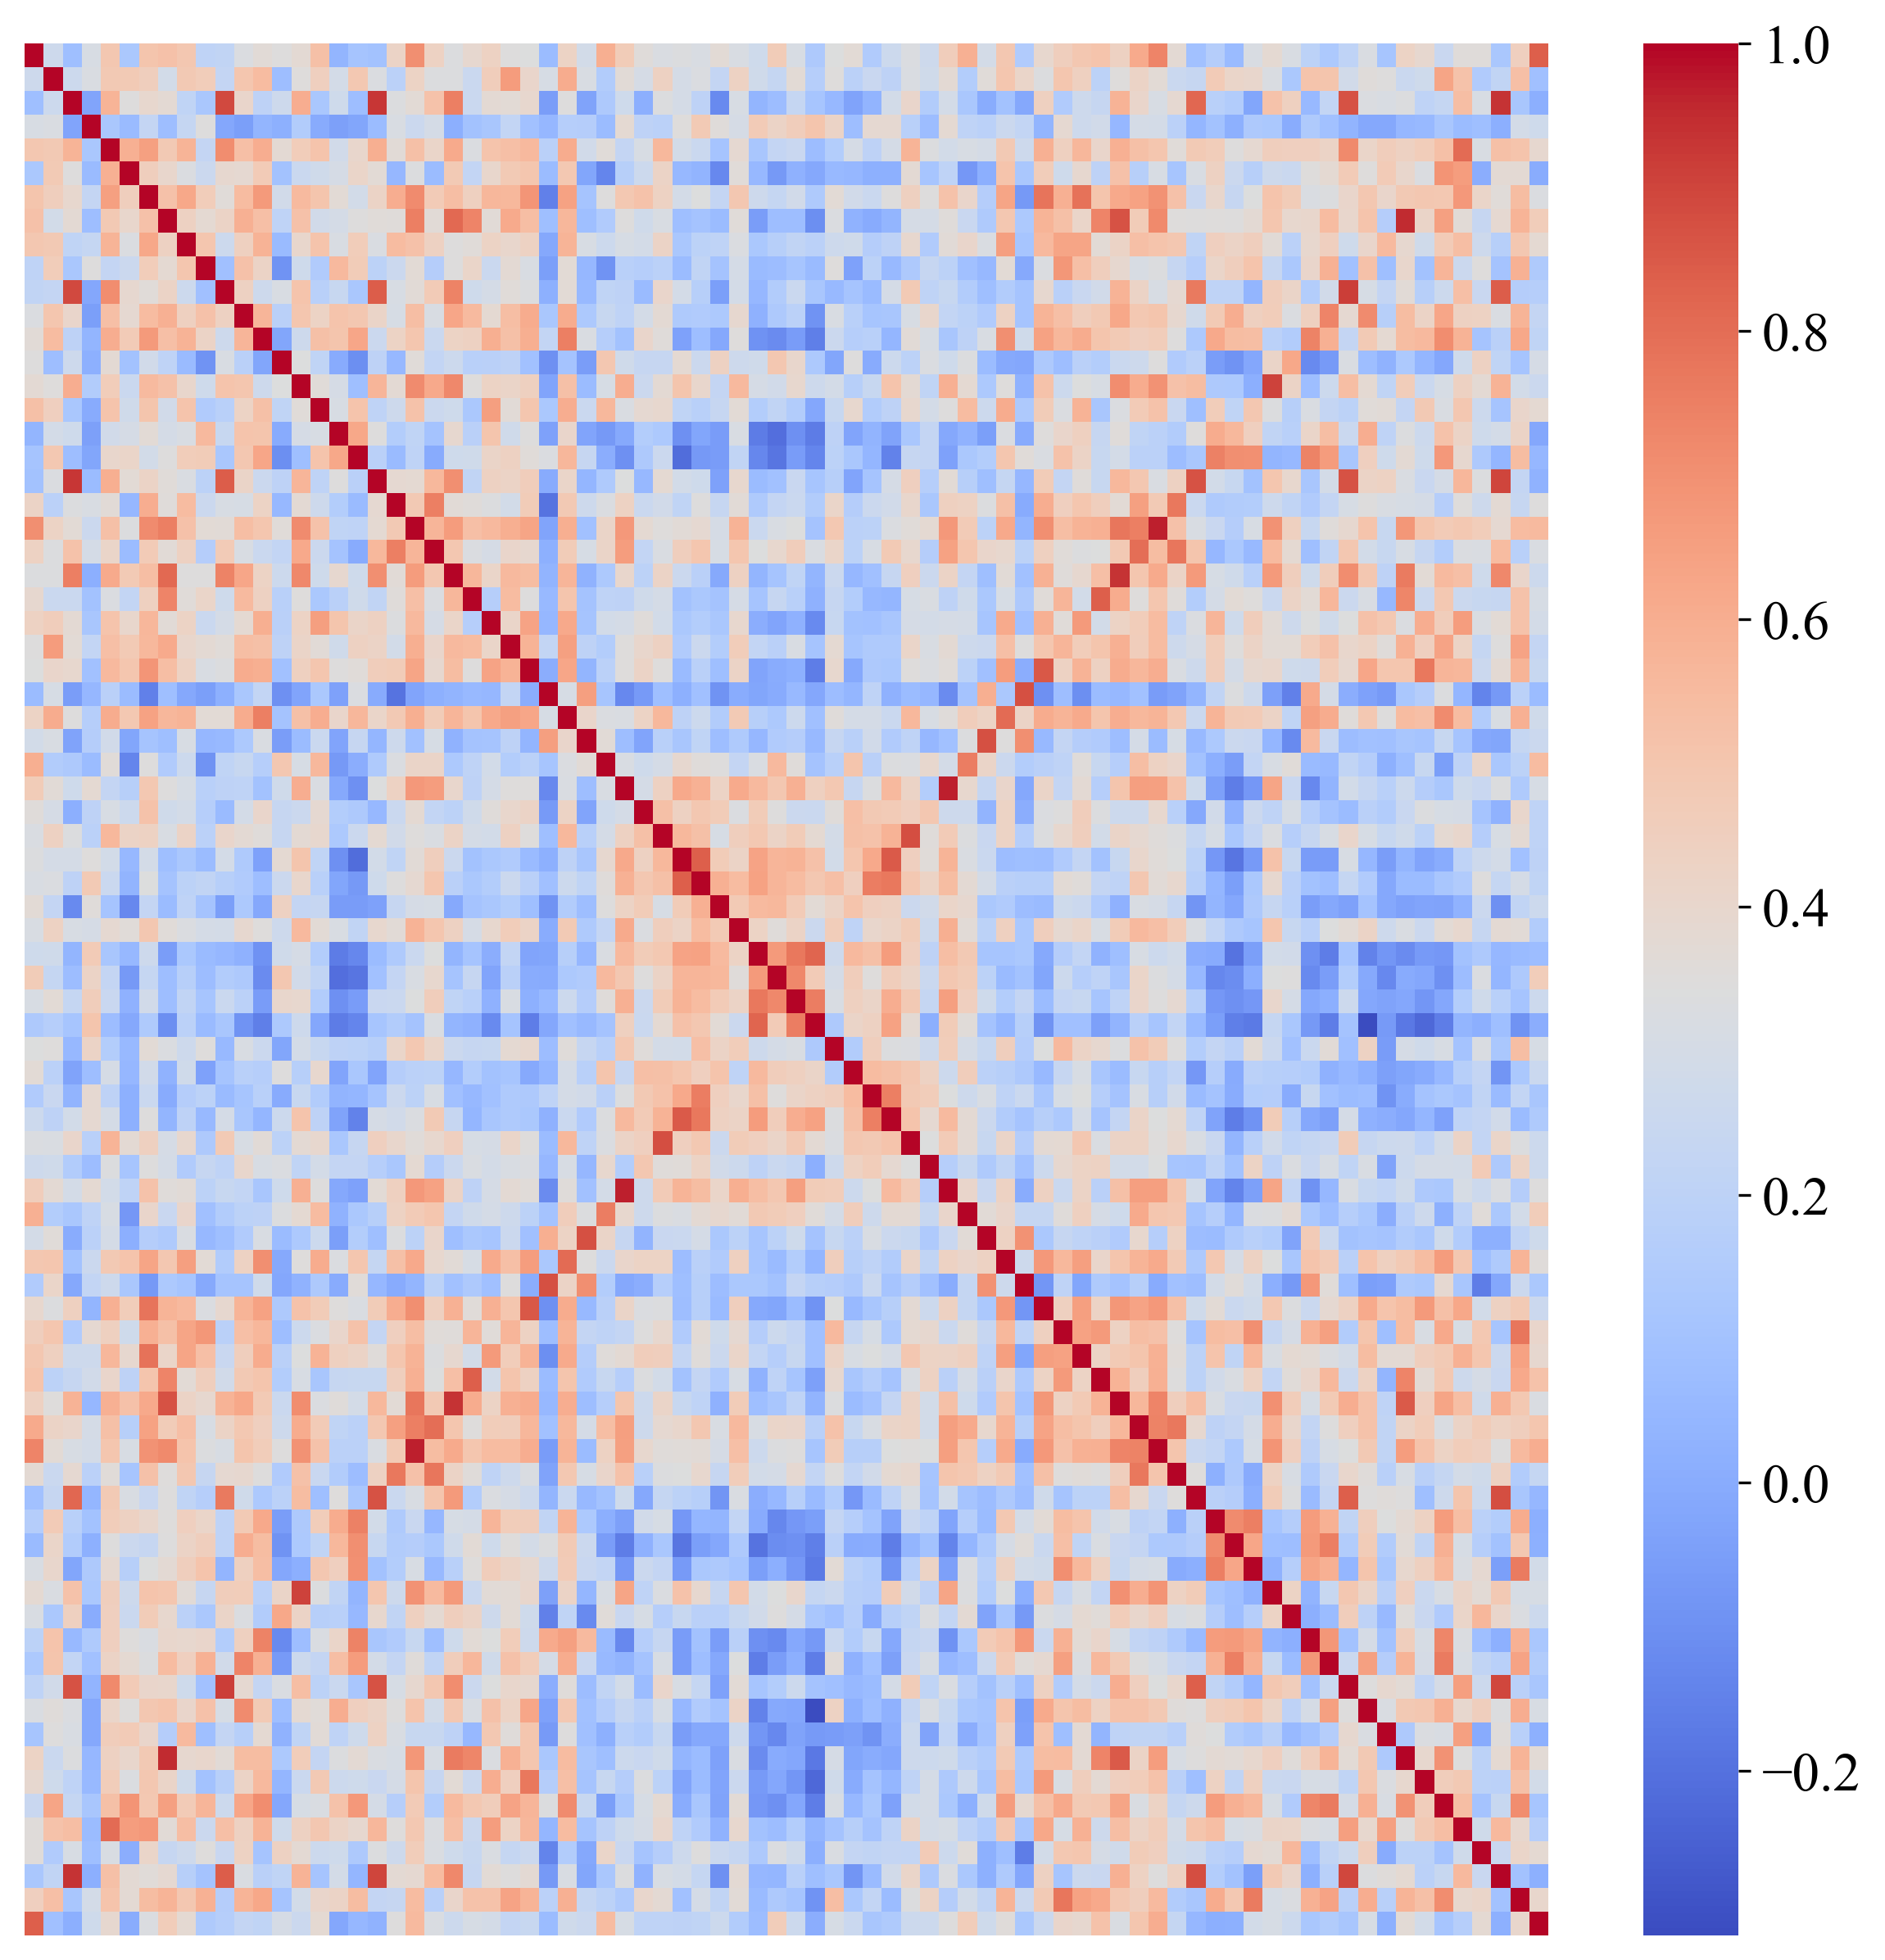

In [28]:
# plot the average correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrices[-1], xticklabels=False, yticklabels=False, cmap='coolwarm')
plt.show()

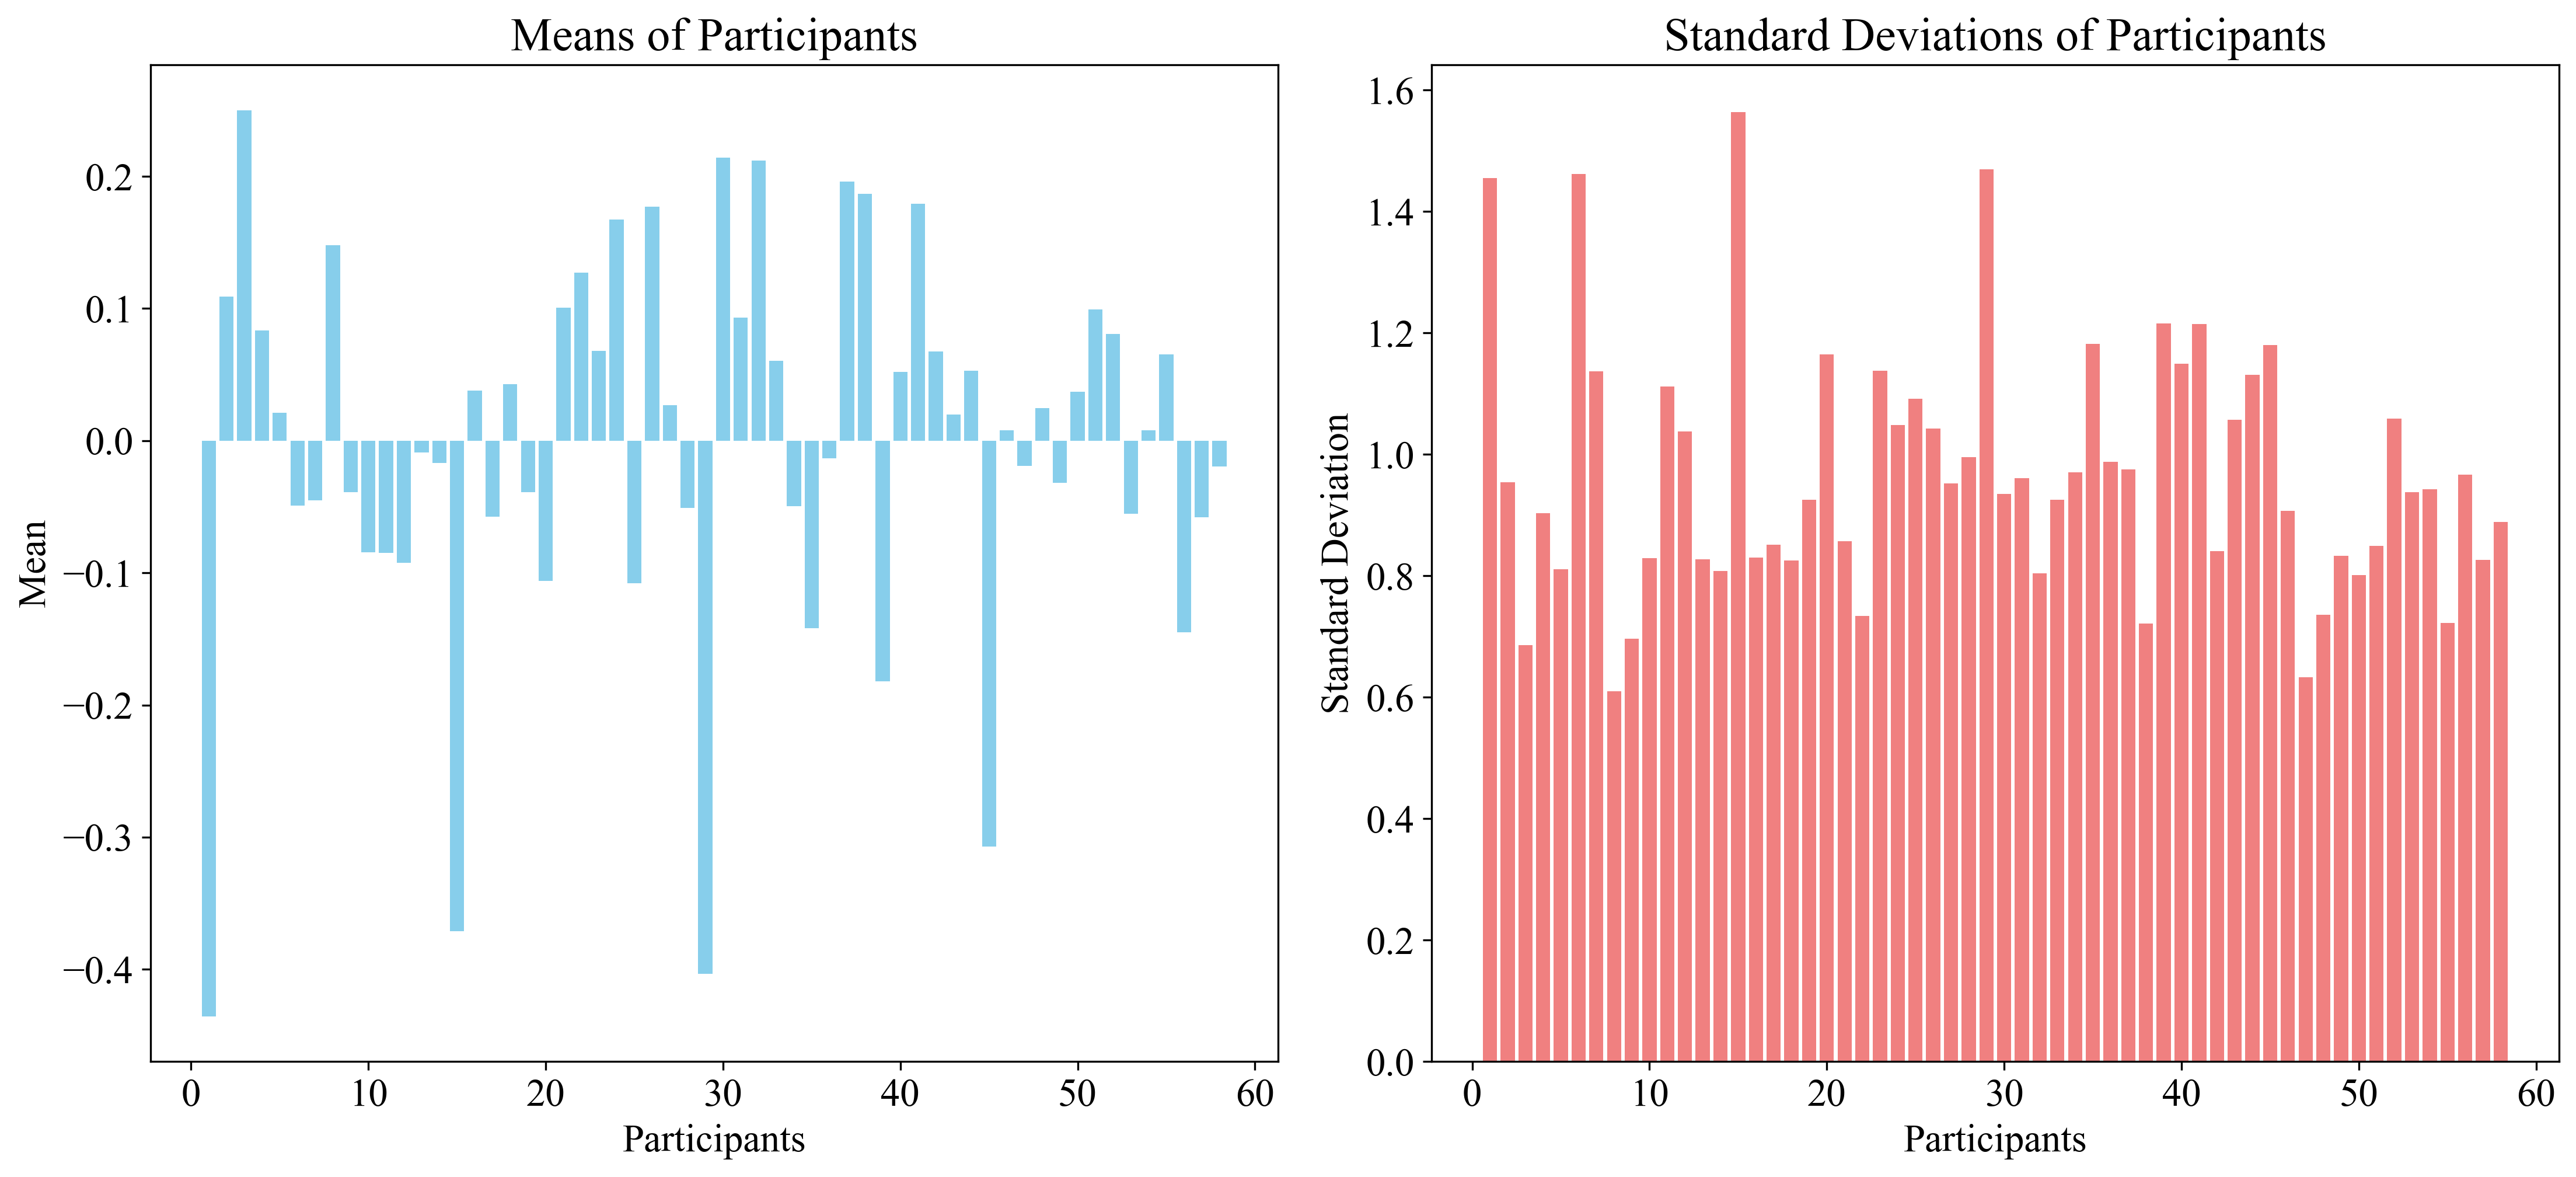

In [29]:
# Participant data
participants = range(1, 59)

# Plotting
plt.figure(figsize=(15, 7))

# Means
plt.subplot(1, 2, 1)
plt.bar(participants, means, color='skyblue')
plt.xlabel('Participants')
plt.ylabel('Mean')
plt.title('Means of Participants')

# Standard Deviations
plt.subplot(1, 2, 2)
plt.bar(participants, stds, color='lightcoral')
plt.xlabel('Participants')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviations of Participants')

plt.tight_layout()
plt.show()

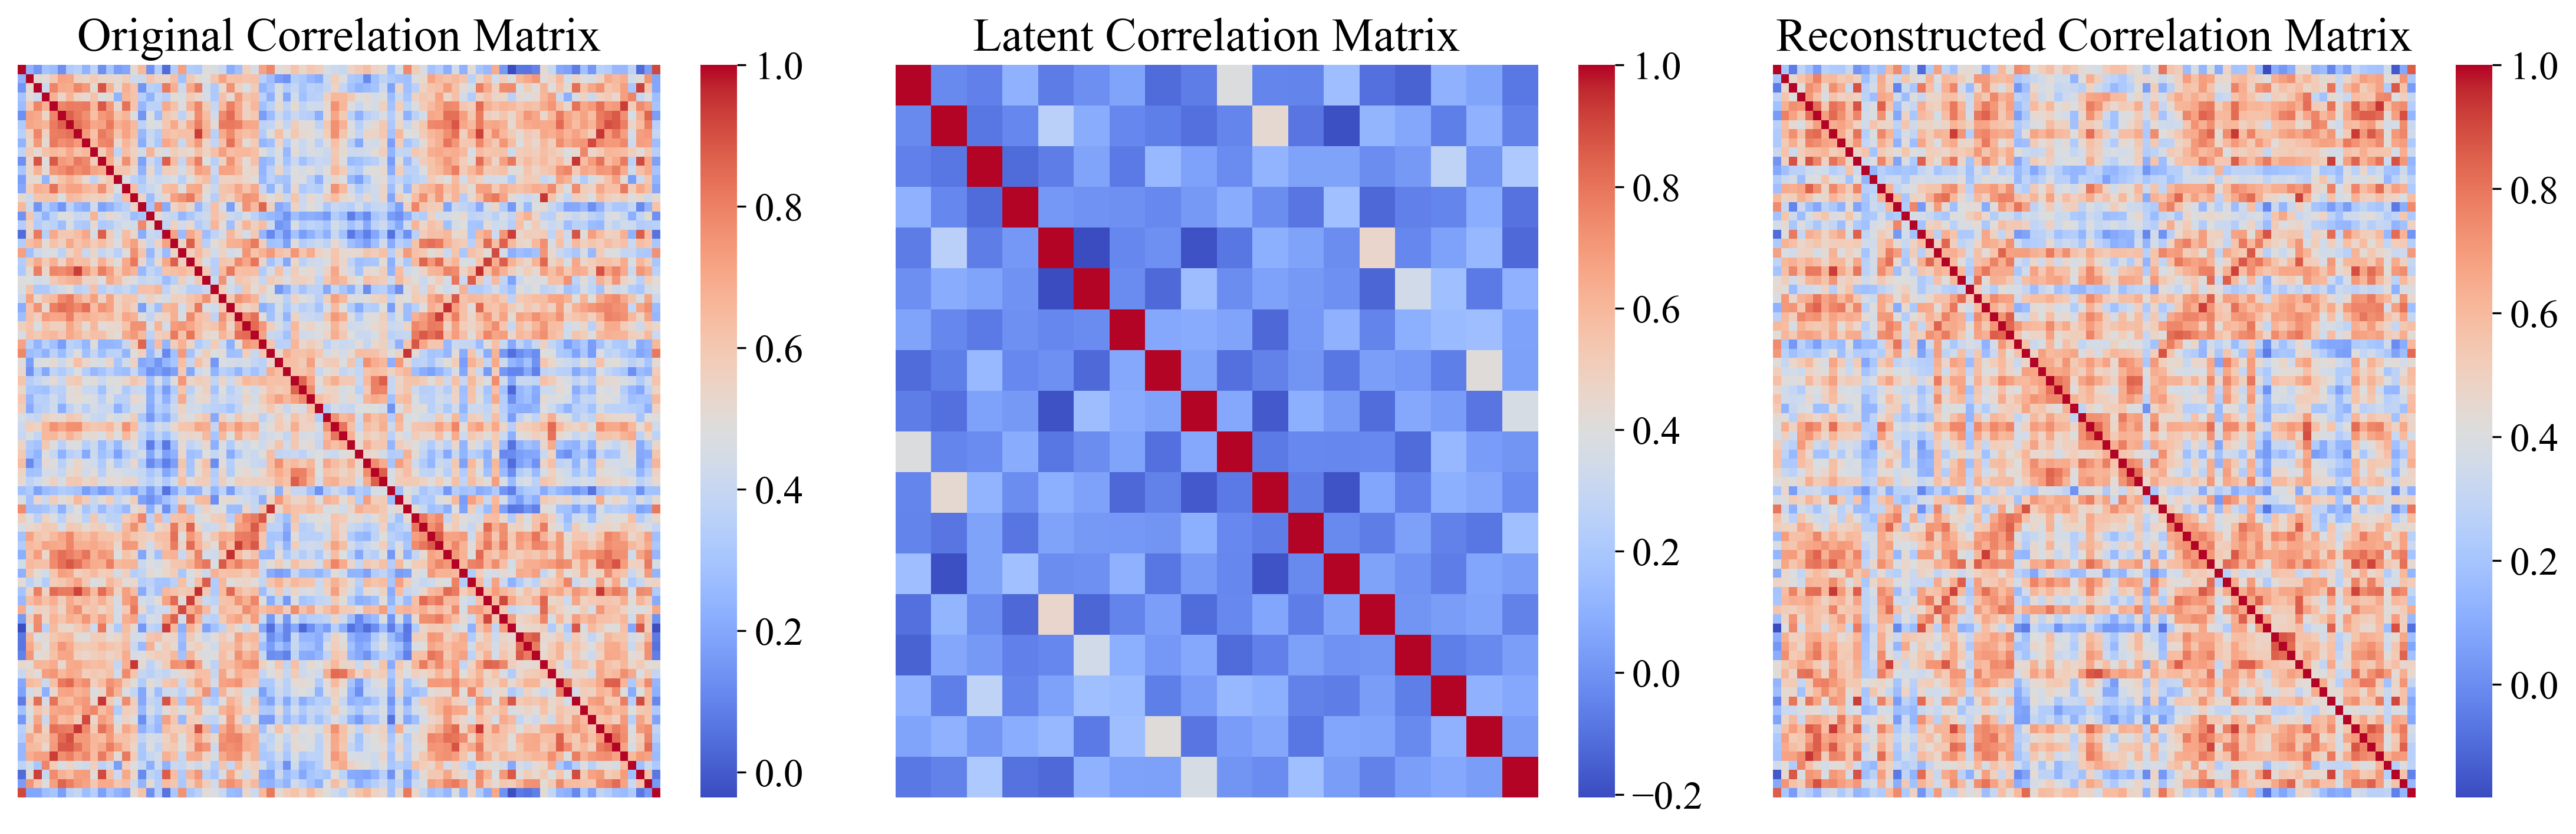

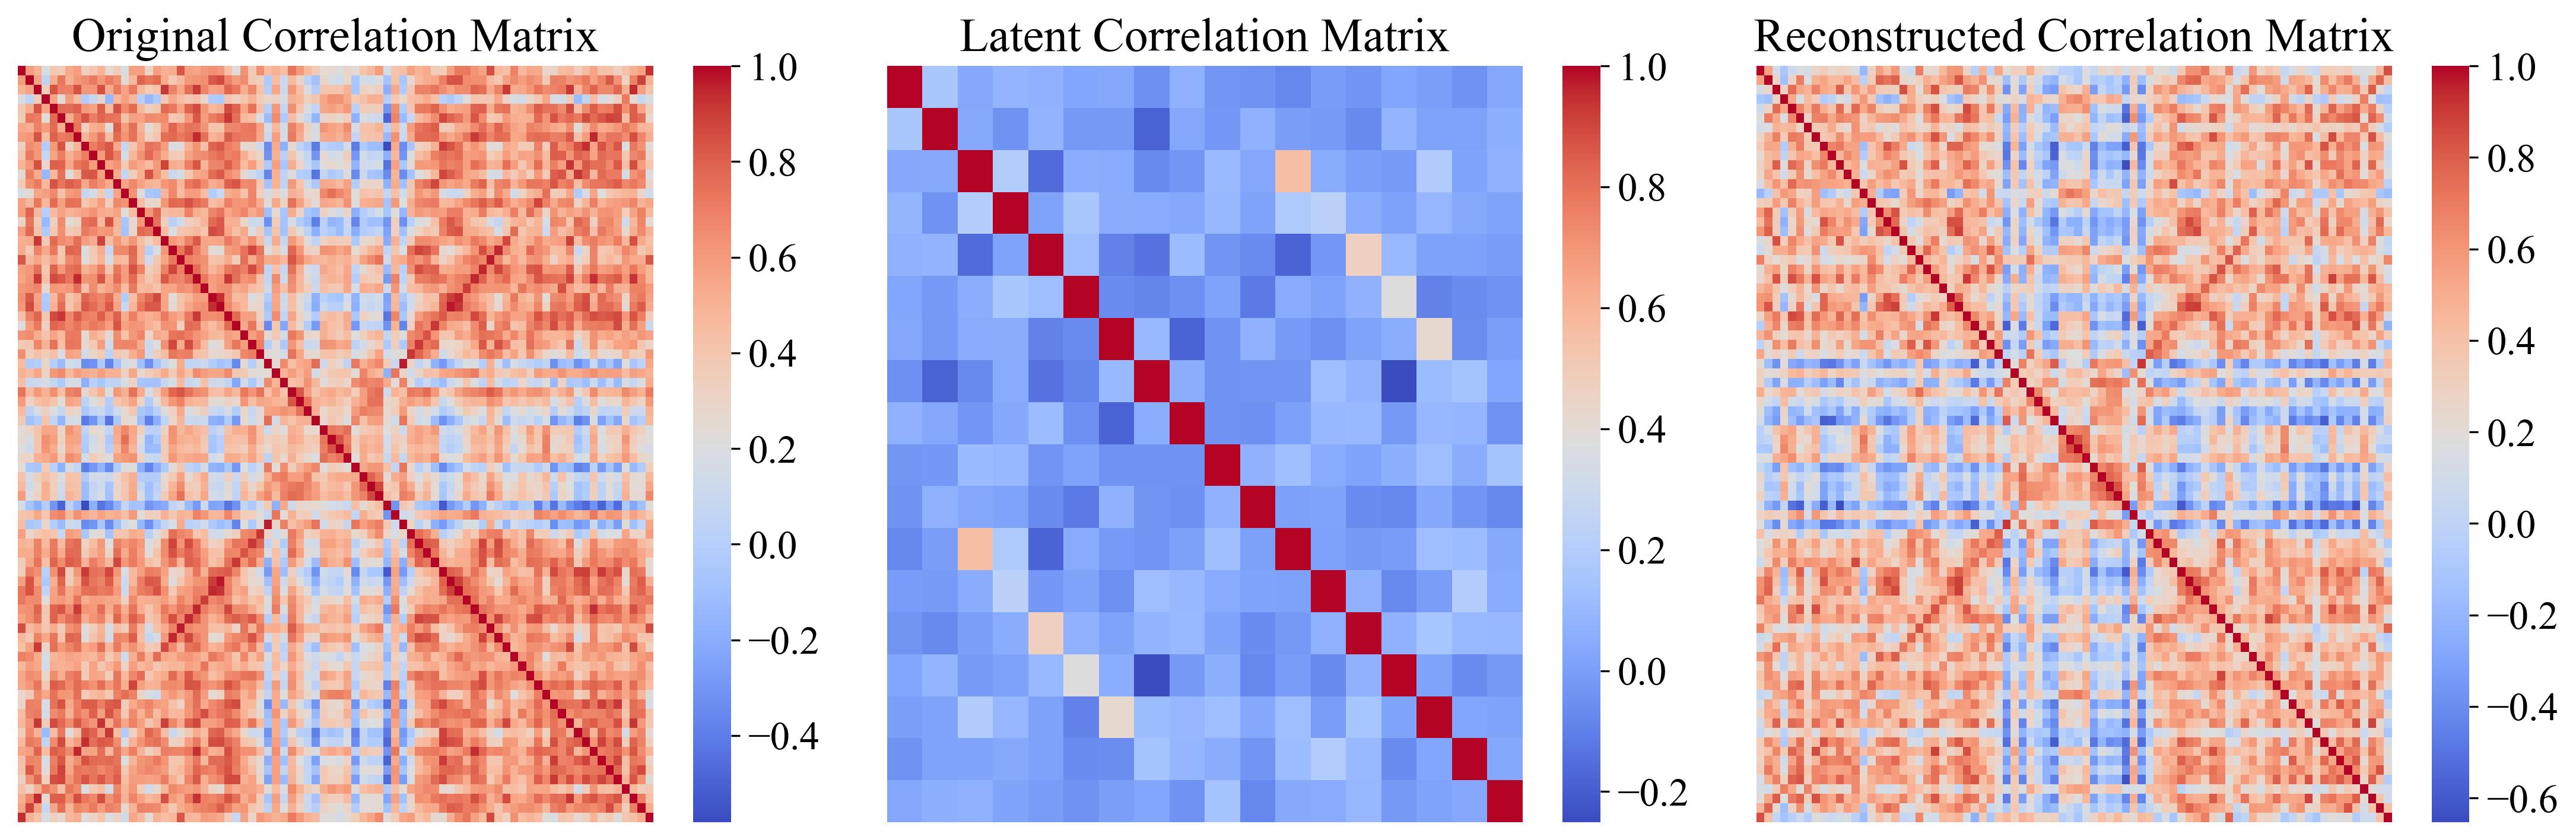

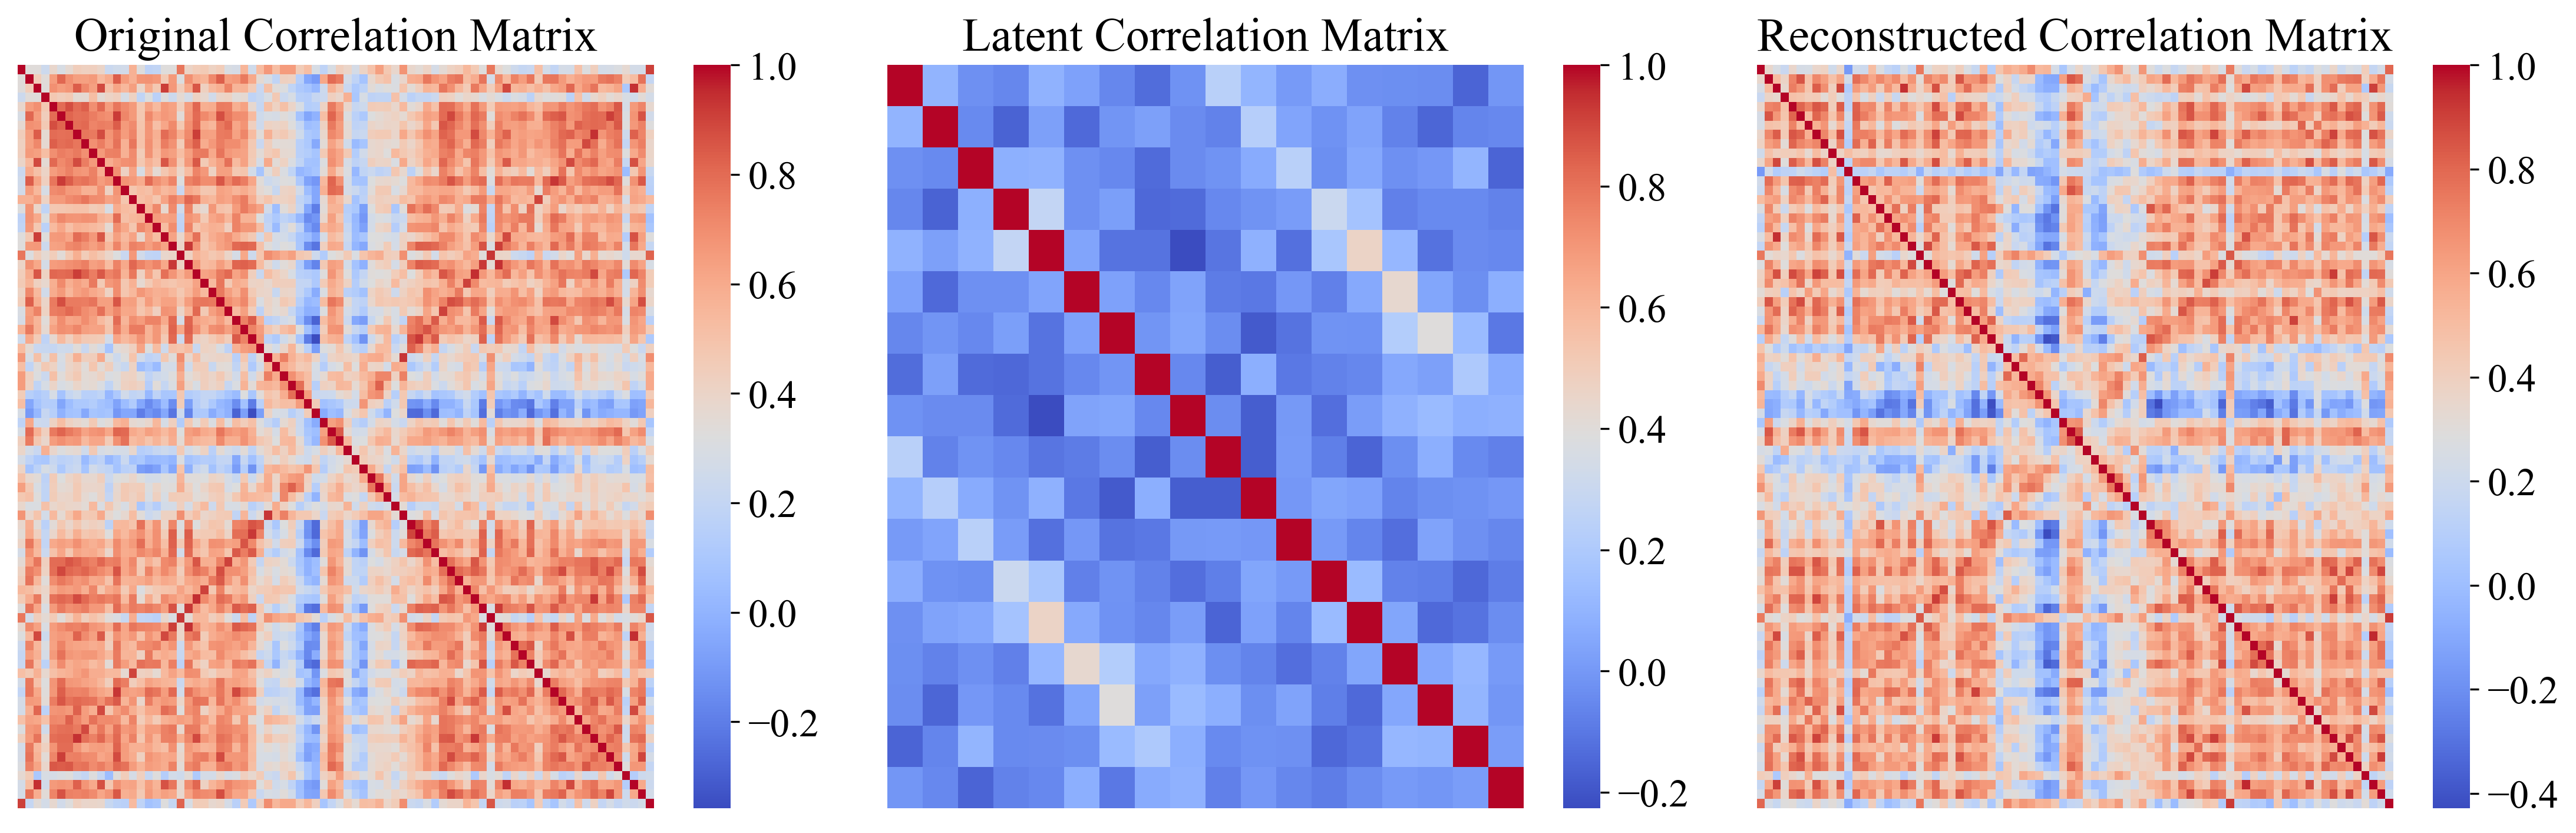

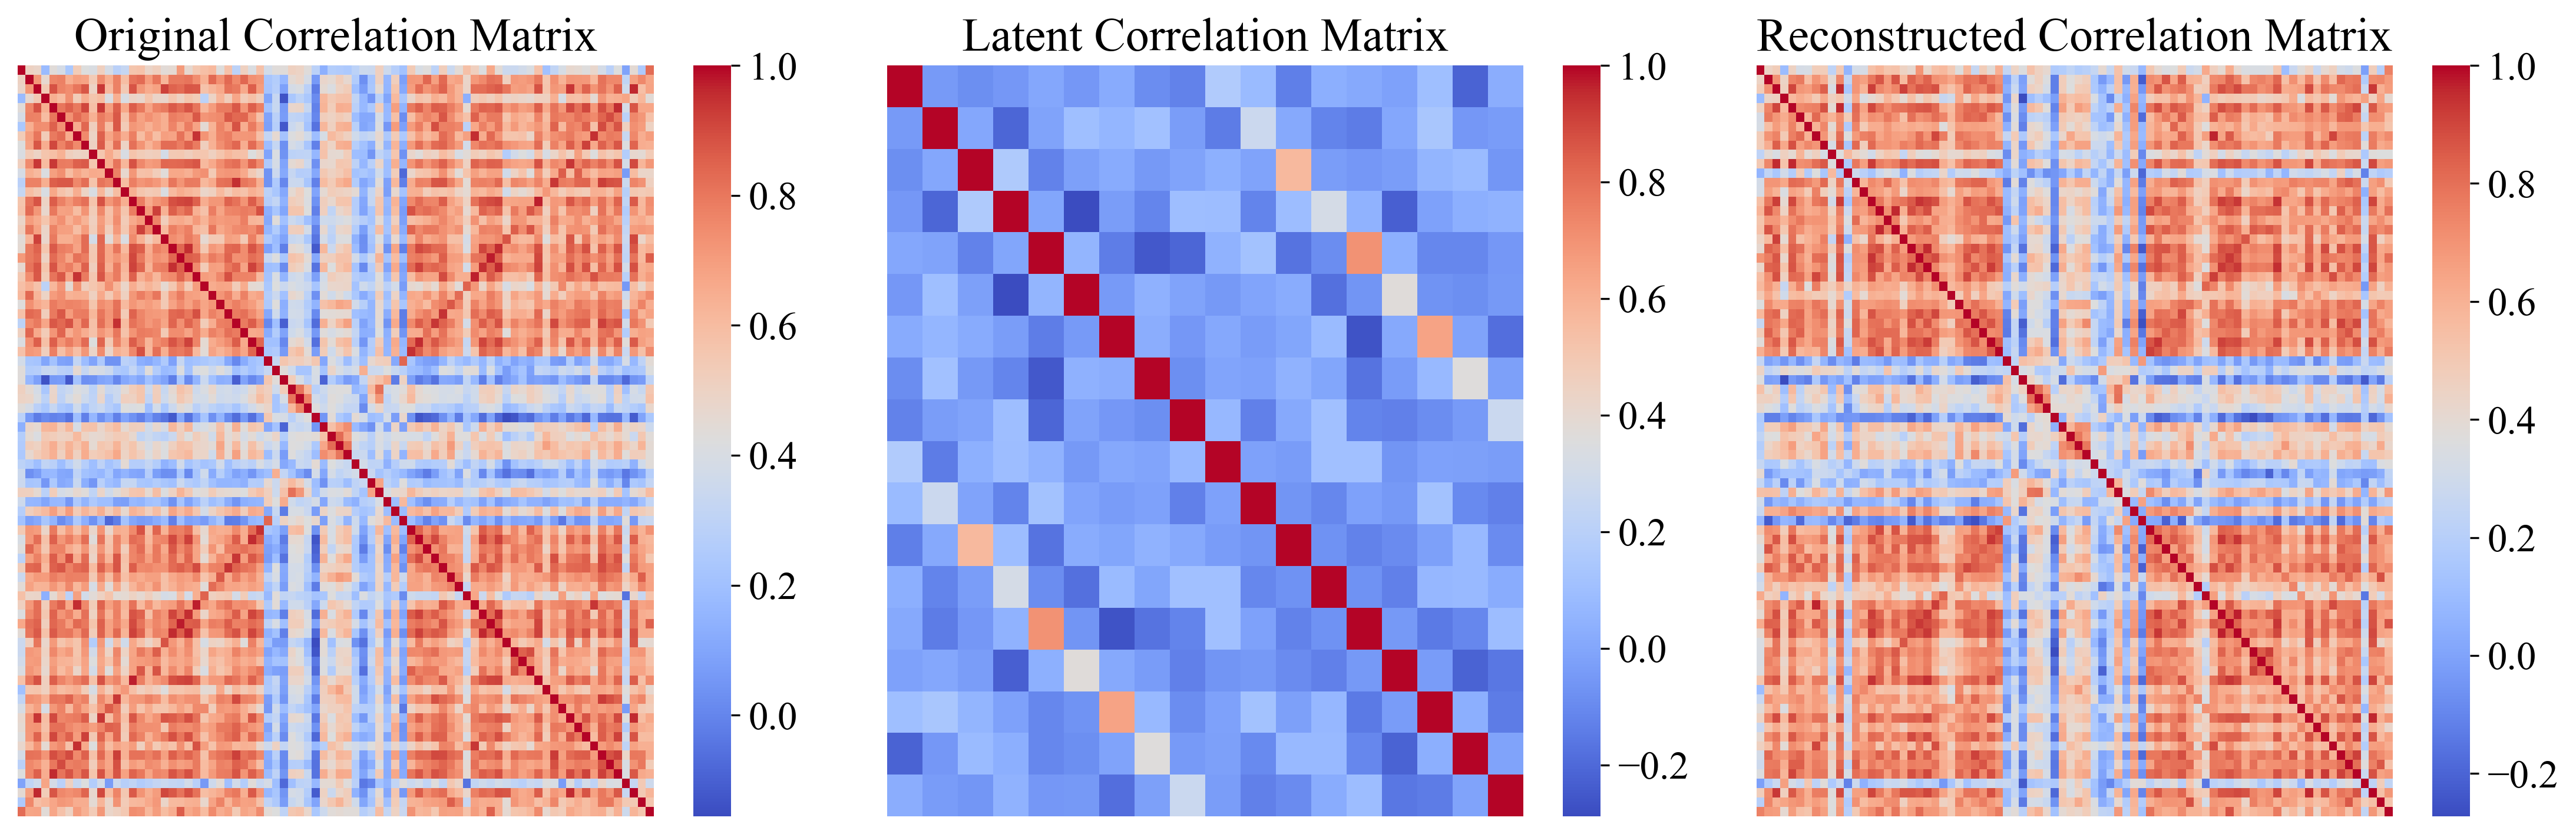

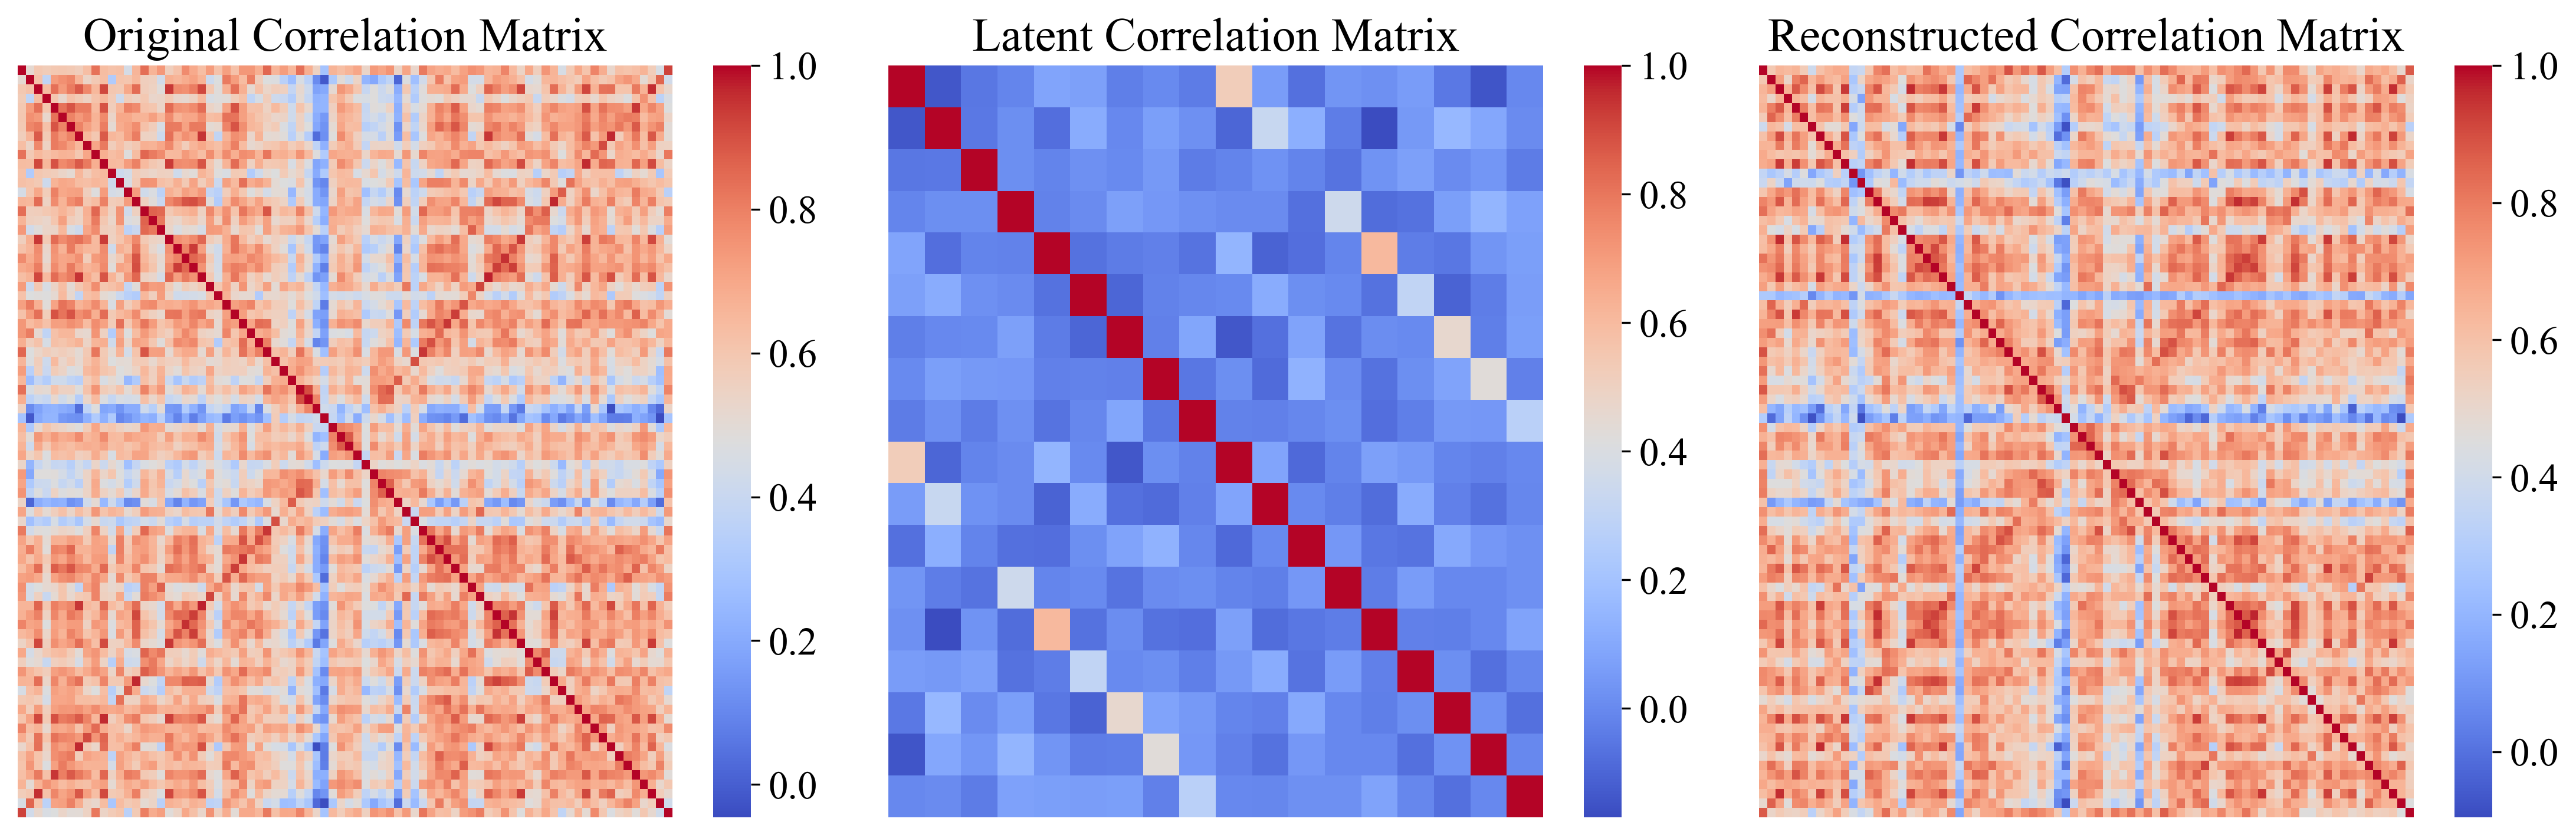

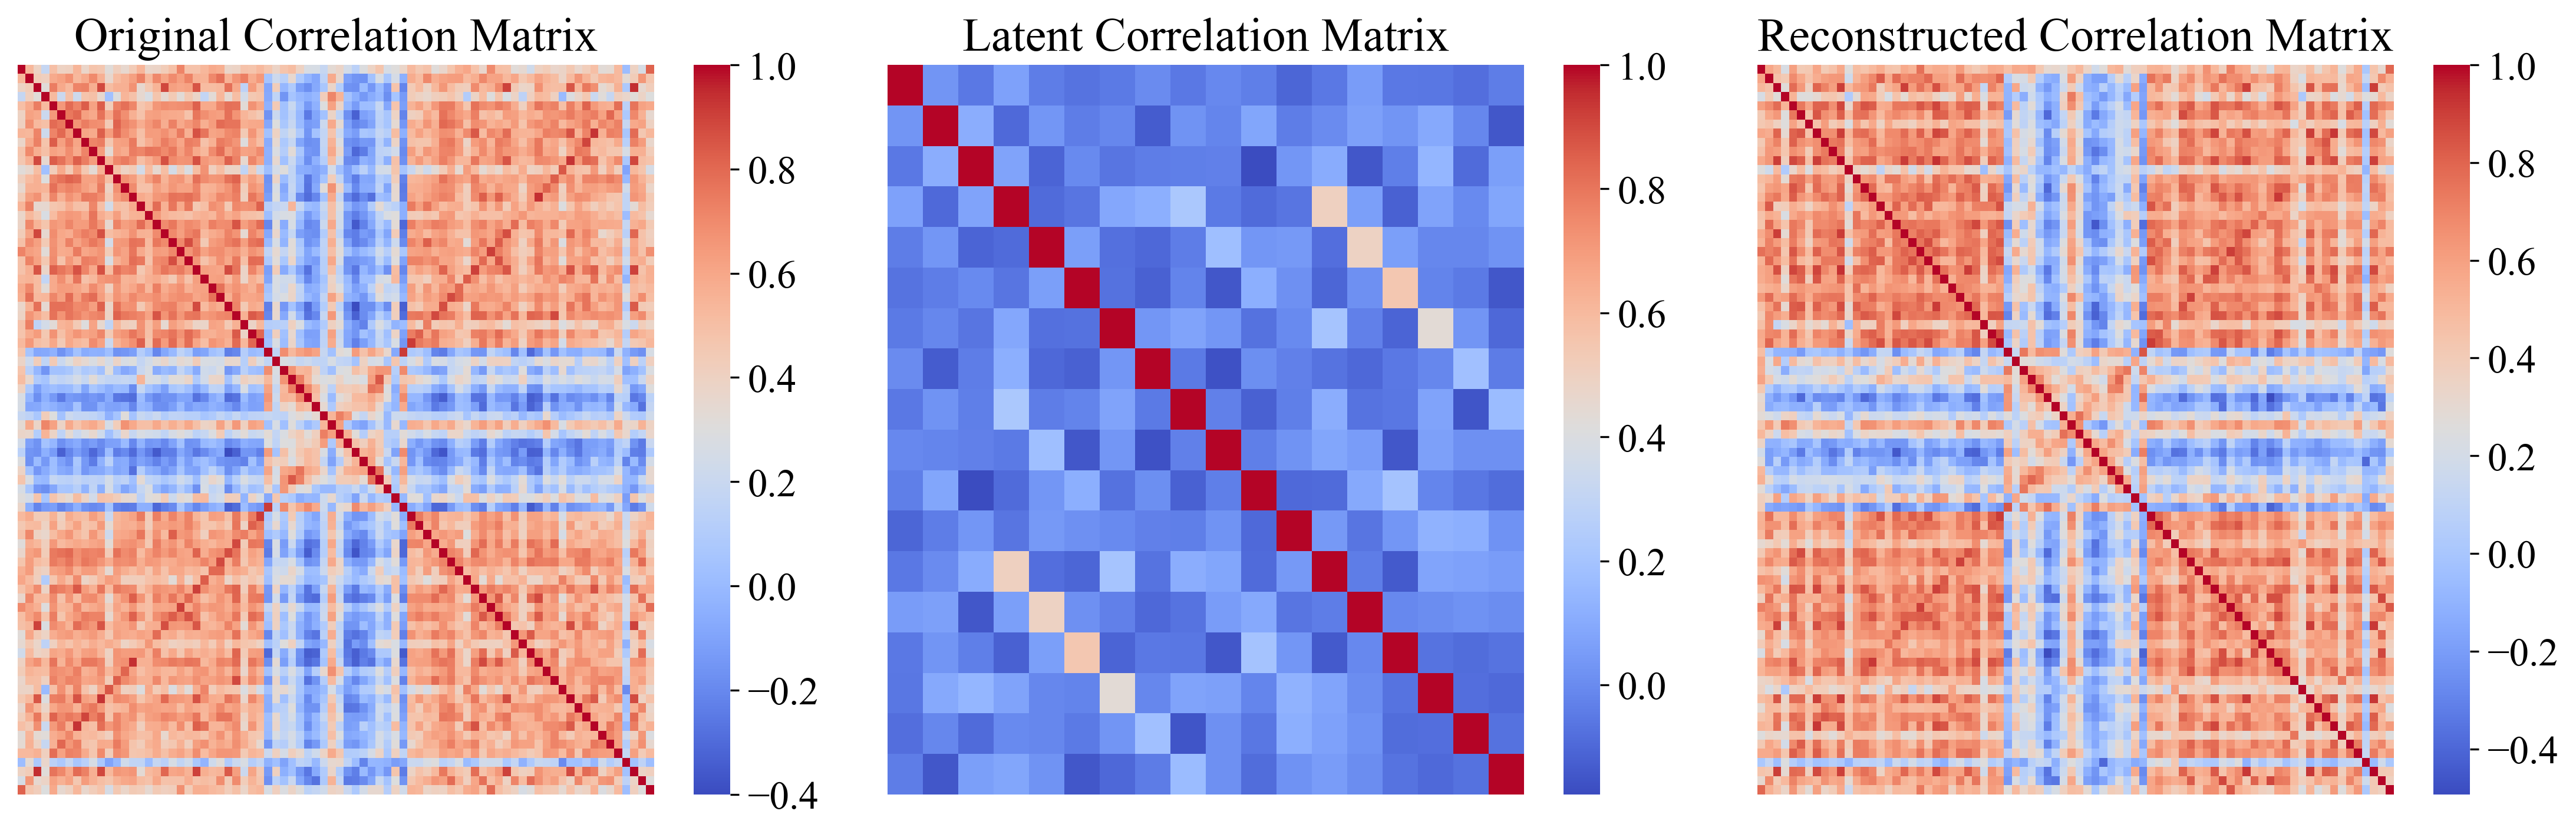

In [30]:
# Load the best model
latent_dim = 18
model = Autoencoder(latent_dim=latent_dim)
model.load_state_dict(torch.load(f'./models/doubleDropout/AE_results_lat18.pt'))
model.eval()

# Load and preprocess data
# Assuming 'concatenated_data' has been previously loaded and preprocessed
concatenated_data = concatenated_data
num_time_points = 200
num_brain_nodes = 80
num_participants = concatenated_data.shape[0] // num_time_points

# Reshape data
data_tensor = torch.tensor(concatenated_data, dtype=torch.float32)
data_tensor = data_tensor.reshape(num_participants, num_time_points, num_brain_nodes)

with torch.no_grad():
    outputs, latent = model(data_tensor.view(-1, num_brain_nodes))
    reconstructed_data = outputs.view(num_participants, num_time_points, num_brain_nodes)
    latent_data = latent.view(num_participants, num_time_points, latent_dim)

for i in range(15, 21):

    # Original Correlation Matrix
    participant_data = data_tensor[i]
    participant_data_tensor = participant_data.clone().detach()
    original_correlation_matrix = compute_fc_matrix_regular(participant_data_tensor)

    # Latent Correlation Matrix
    participant_latent_data = latent_data[i]
    participant_latent_data_tensor = participant_latent_data.clone().detach()
    latent_correlation_matrix = compute_fc_matrix_regular(participant_latent_data_tensor, num_brain_nodes=latent_dim)

    # Reconstructed Correlation Matrix
    participant_reconstructed_data = reconstructed_data[i]
    participant_reconstructed_data_tensor = participant_reconstructed_data.clone().detach()
    reconstructed_correlation_matrix = compute_fc_matrix_regular(participant_reconstructed_data_tensor)

    # Plot the matrices
    plt.figure(figsize=(15, 5))

    # Original Correlation Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(original_correlation_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    plt.title('Original Correlation Matrix')

    # Latent Correlation Matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(latent_correlation_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    plt.title('Latent Correlation Matrix')

    # Reconstructed Correlation Matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(reconstructed_correlation_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    plt.title('Reconstructed Correlation Matrix')

    plt.tight_layout()
    plt.show()

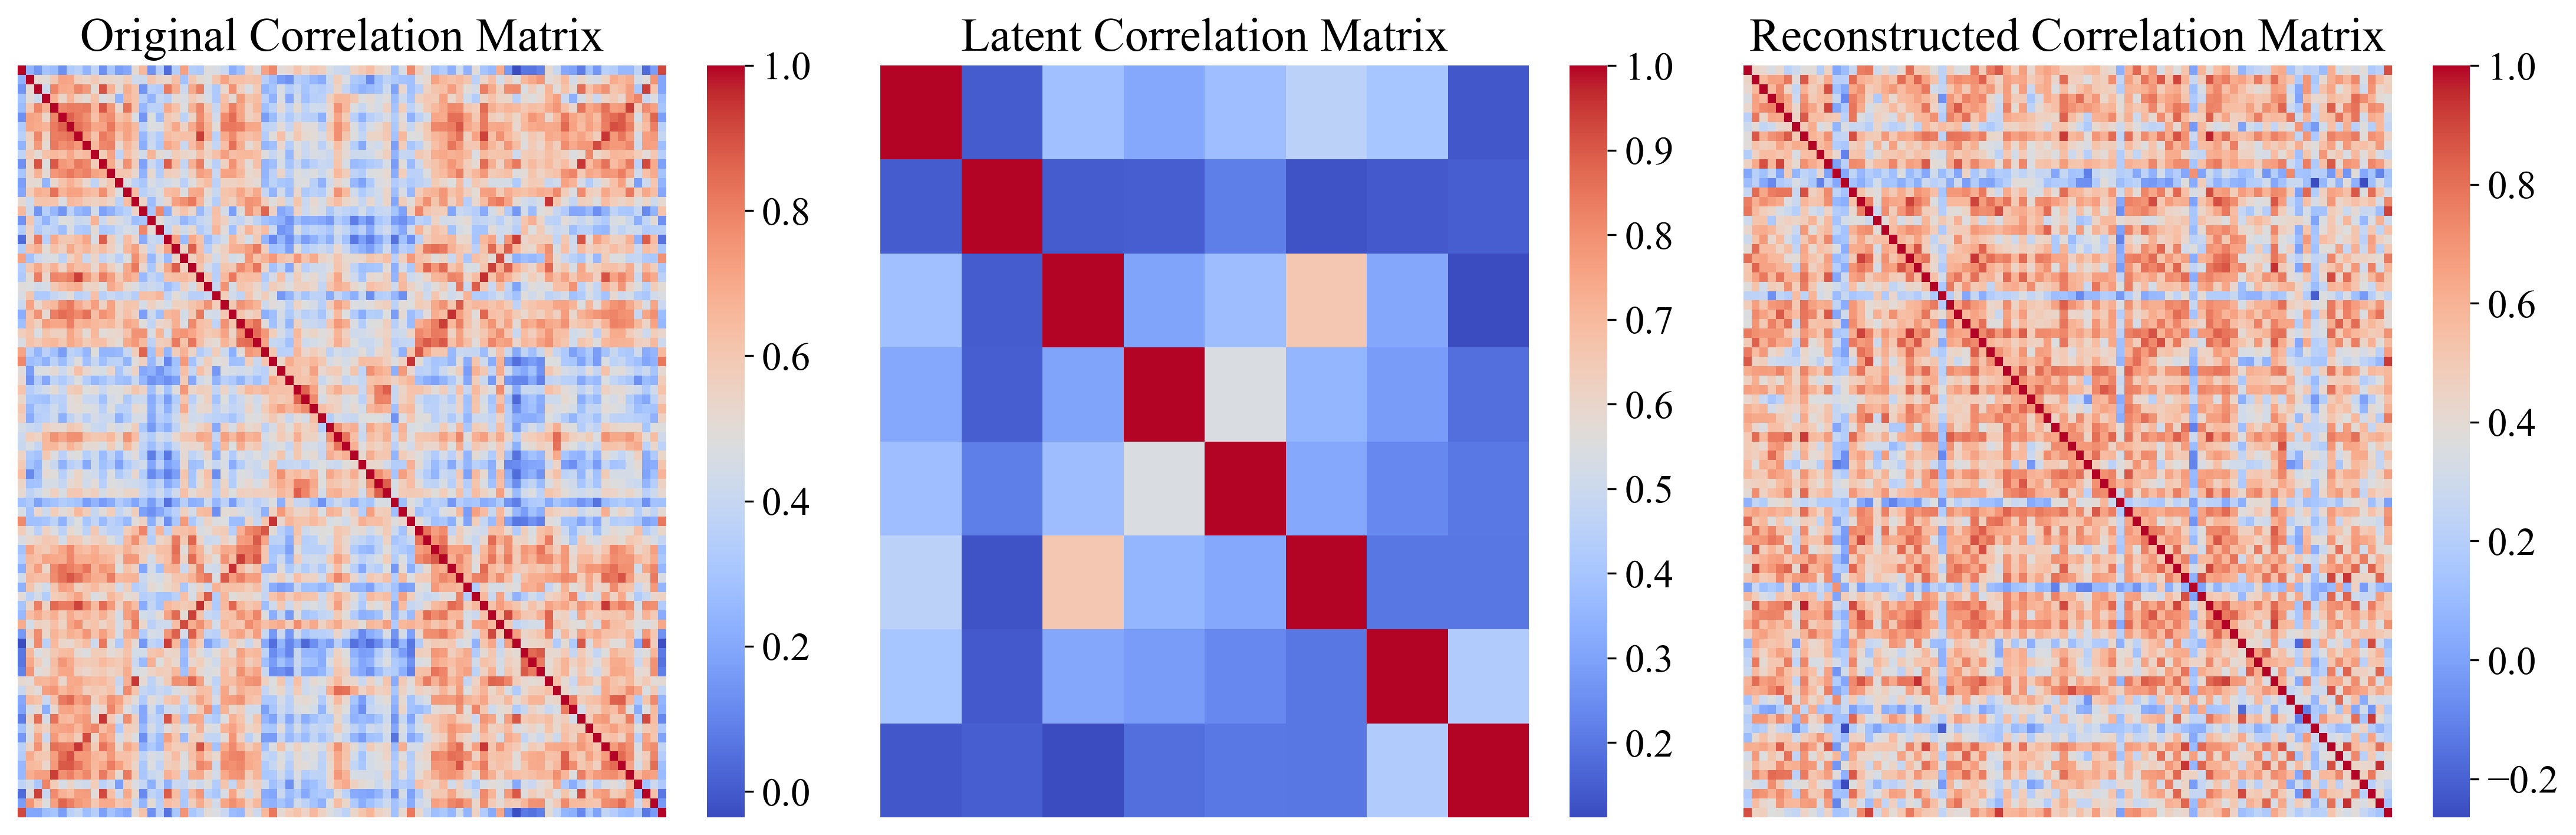

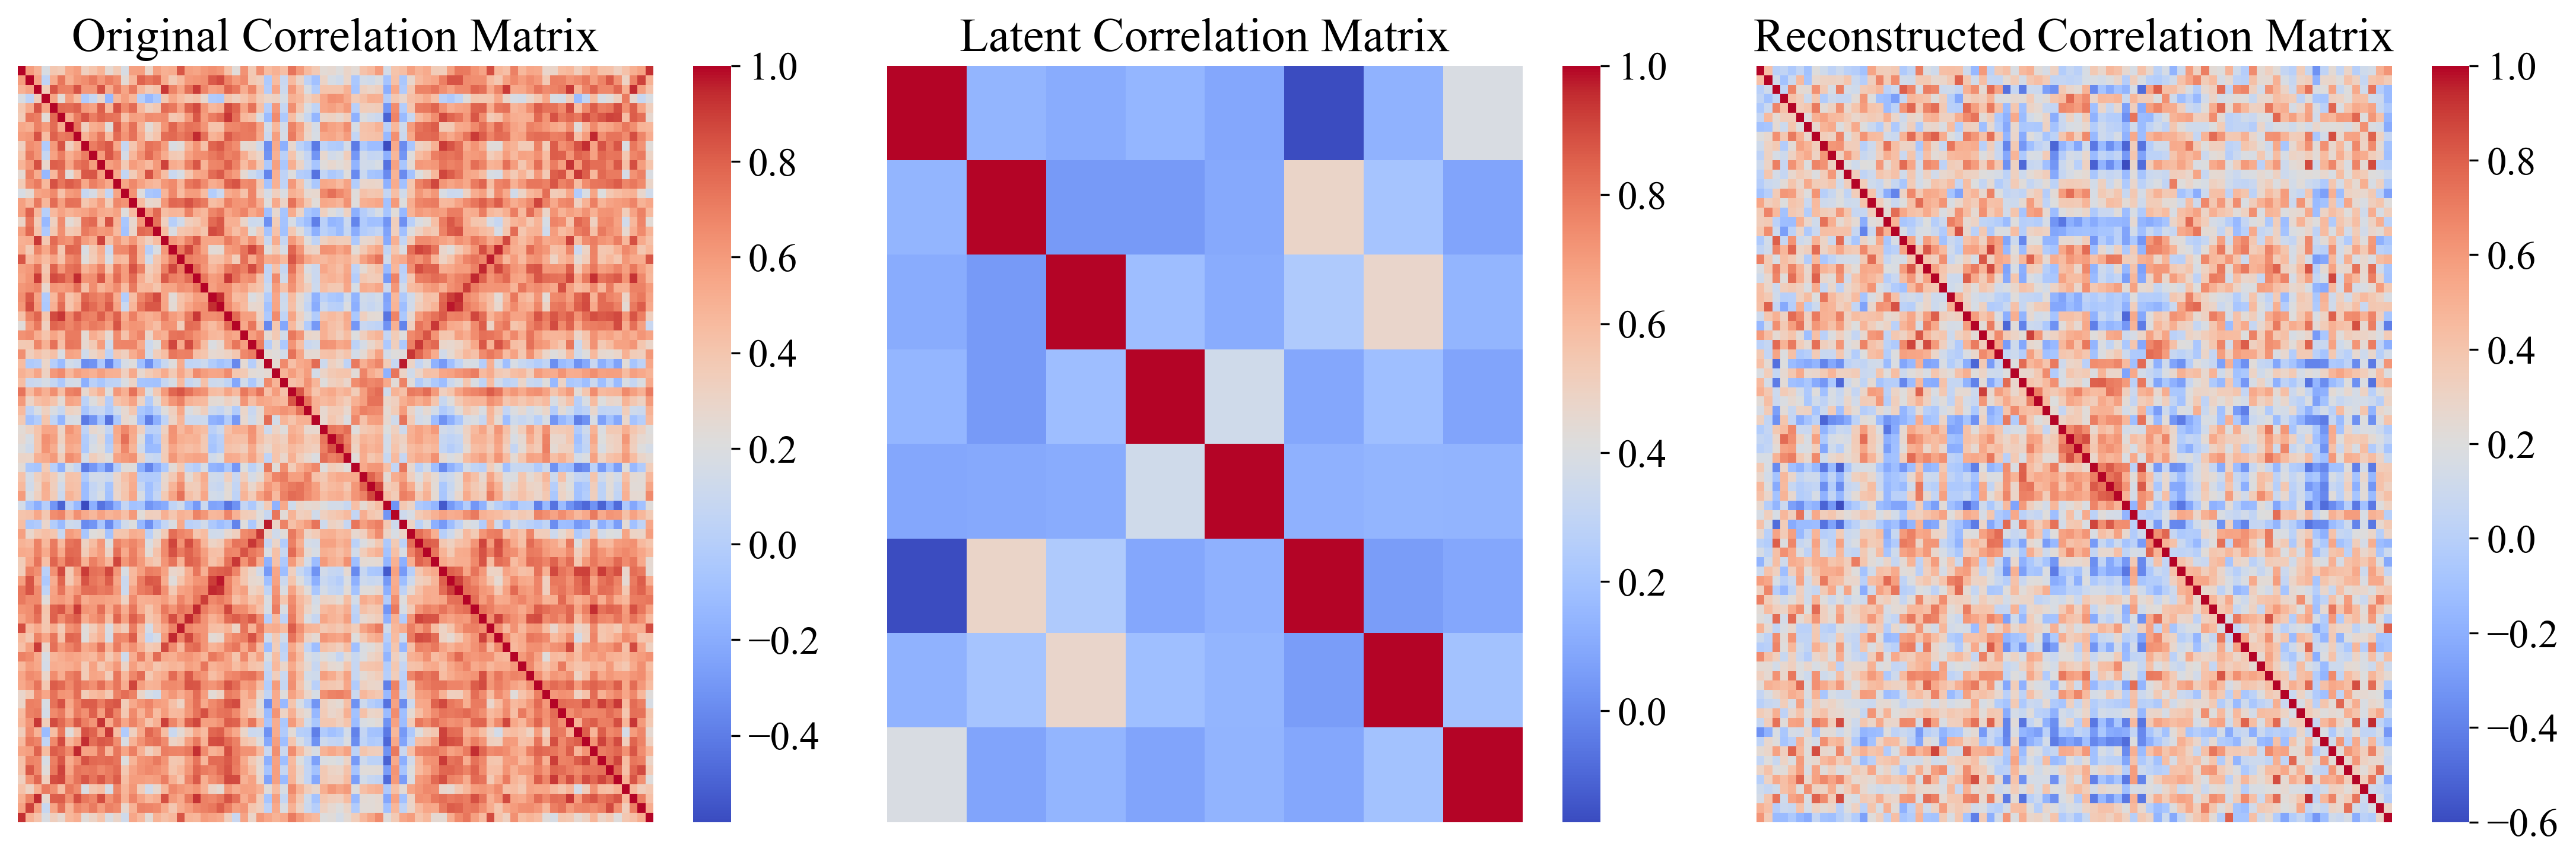

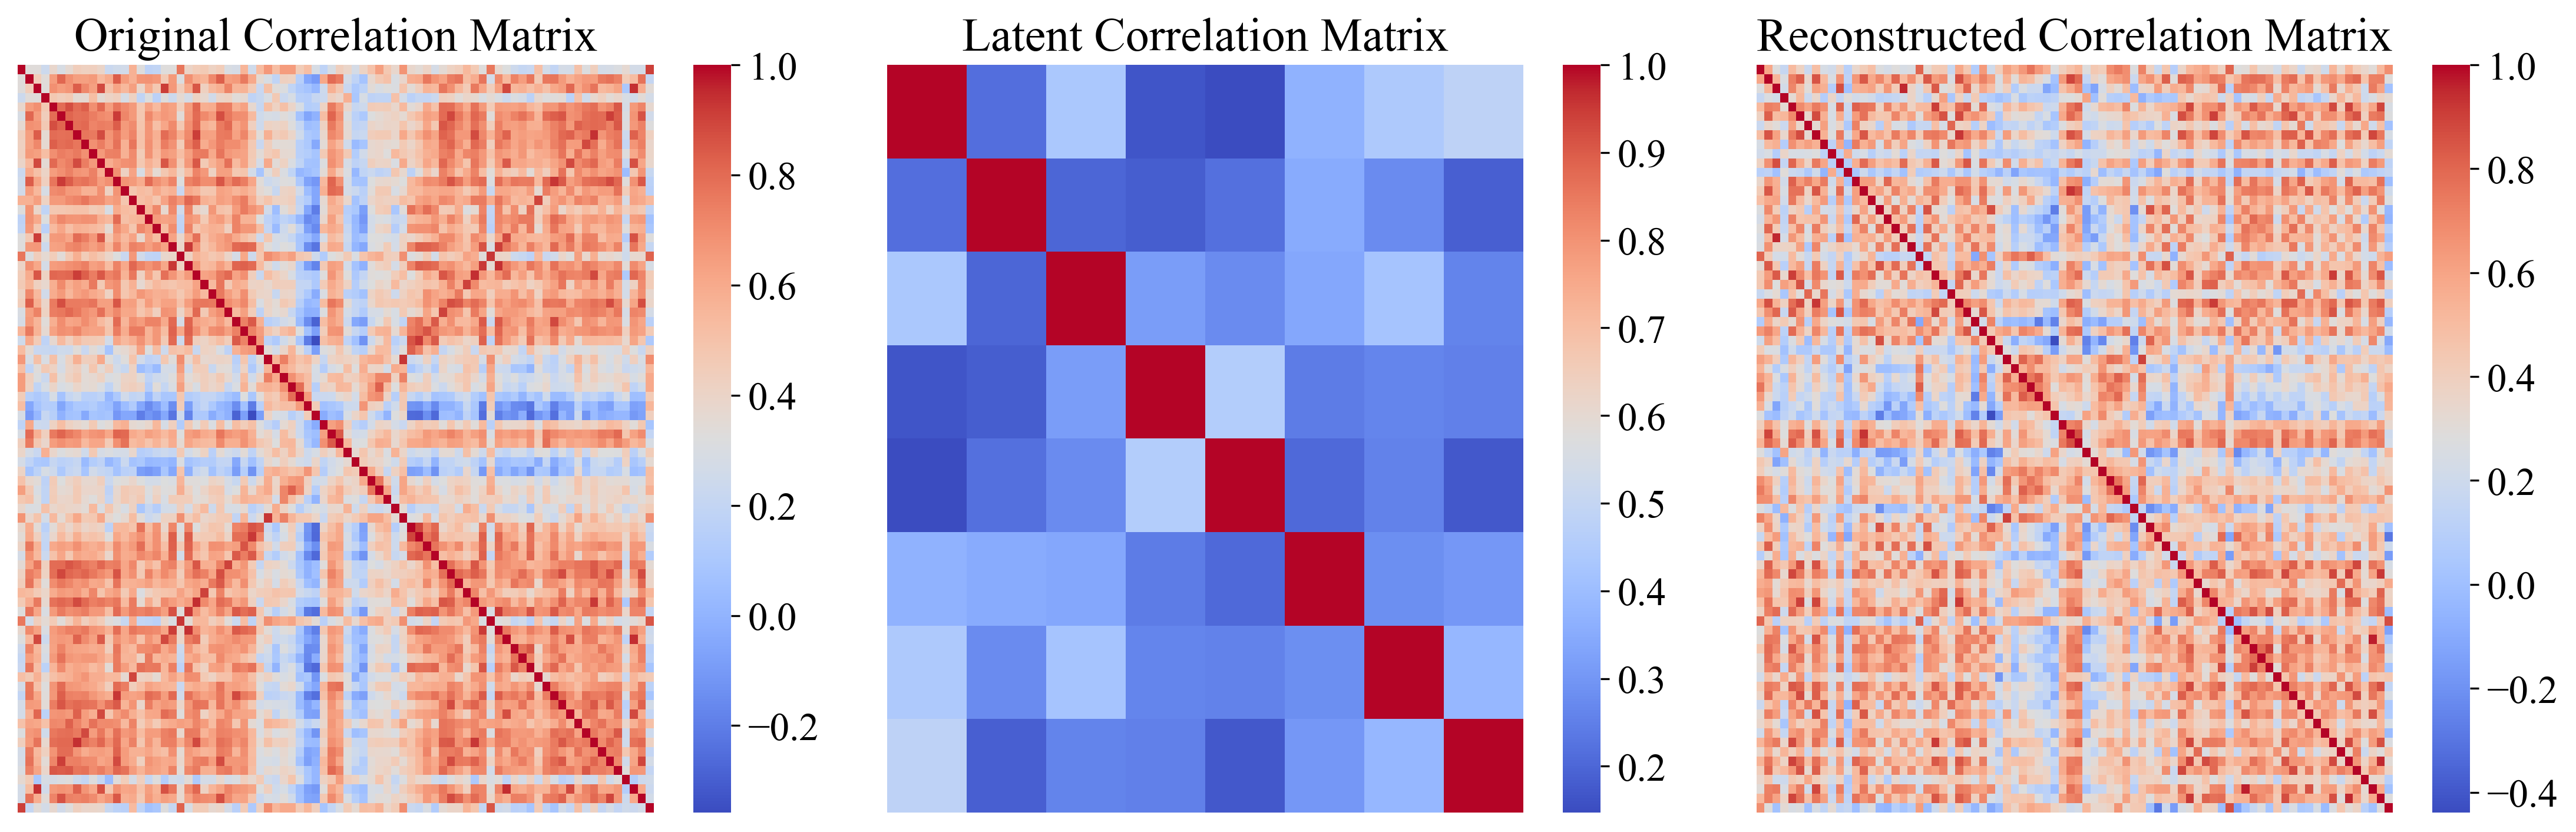

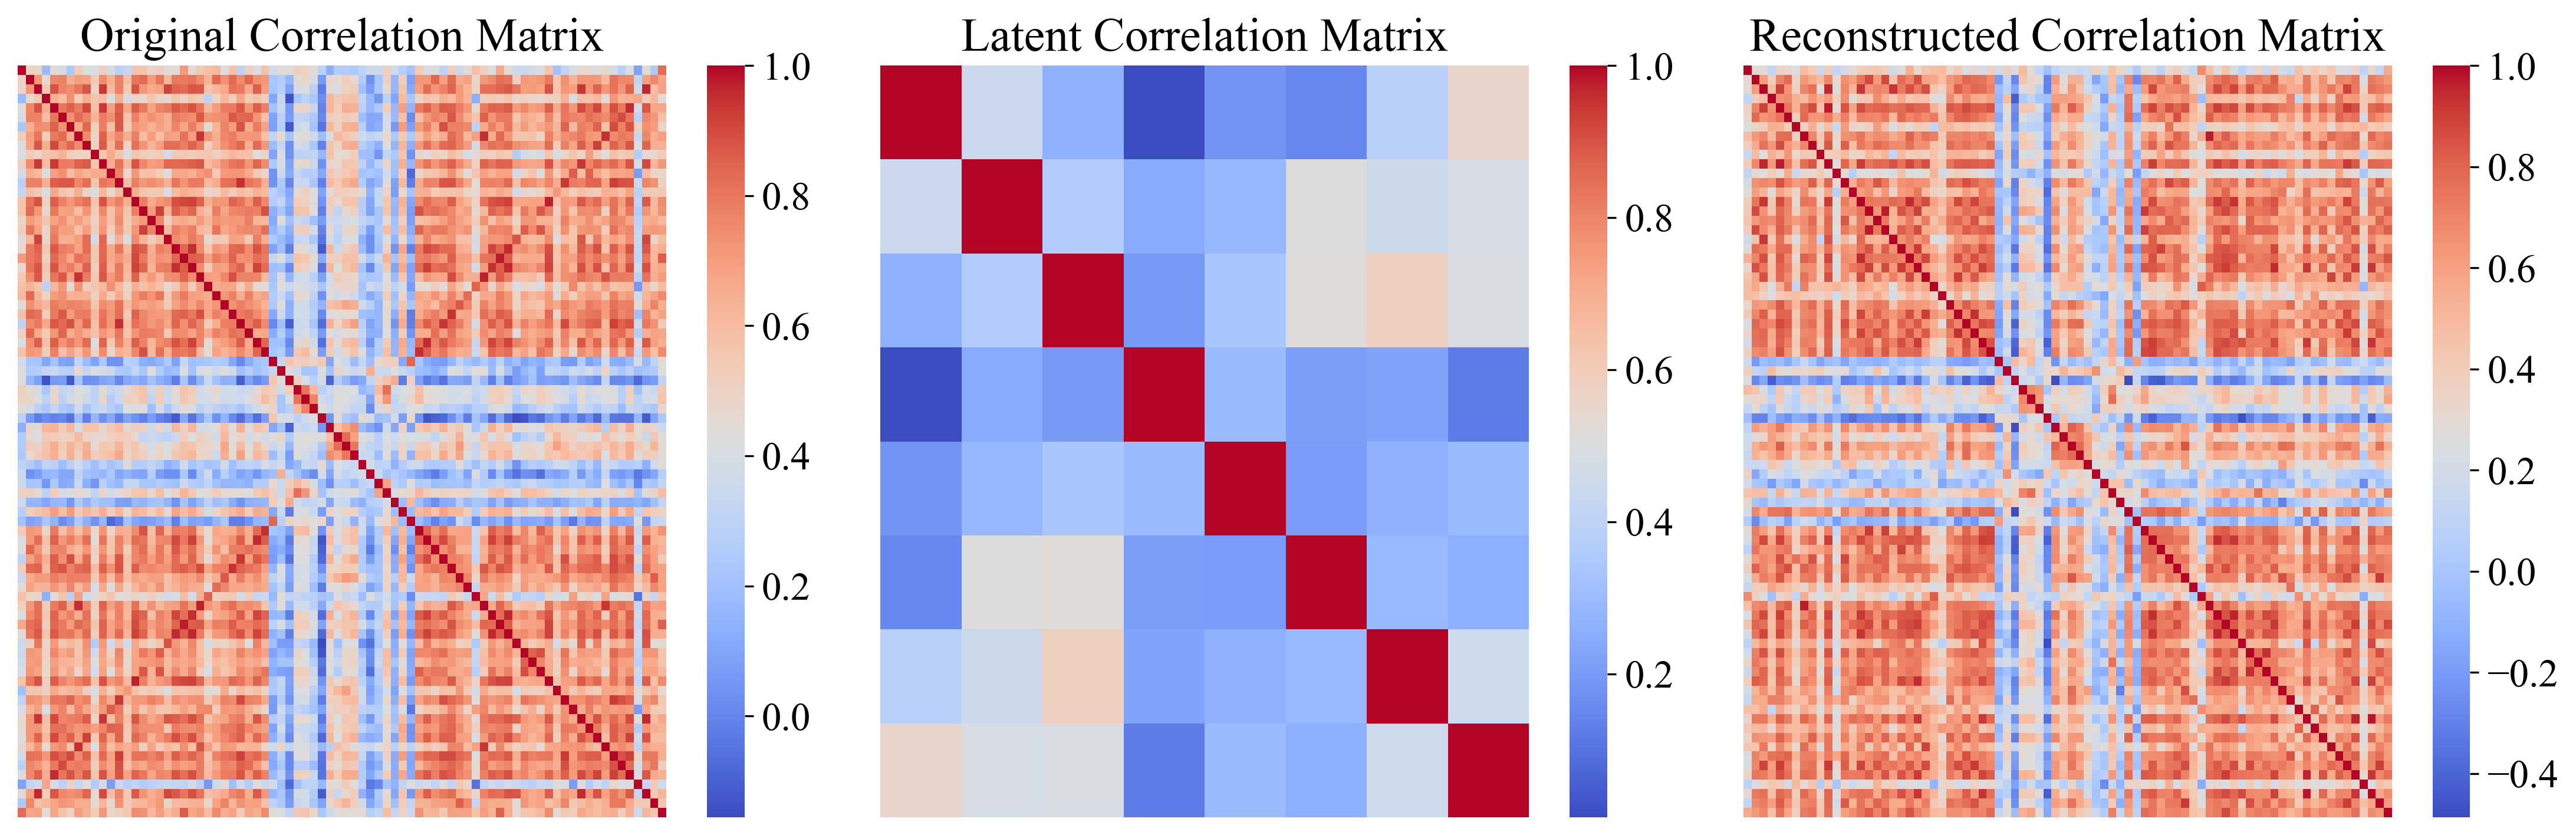

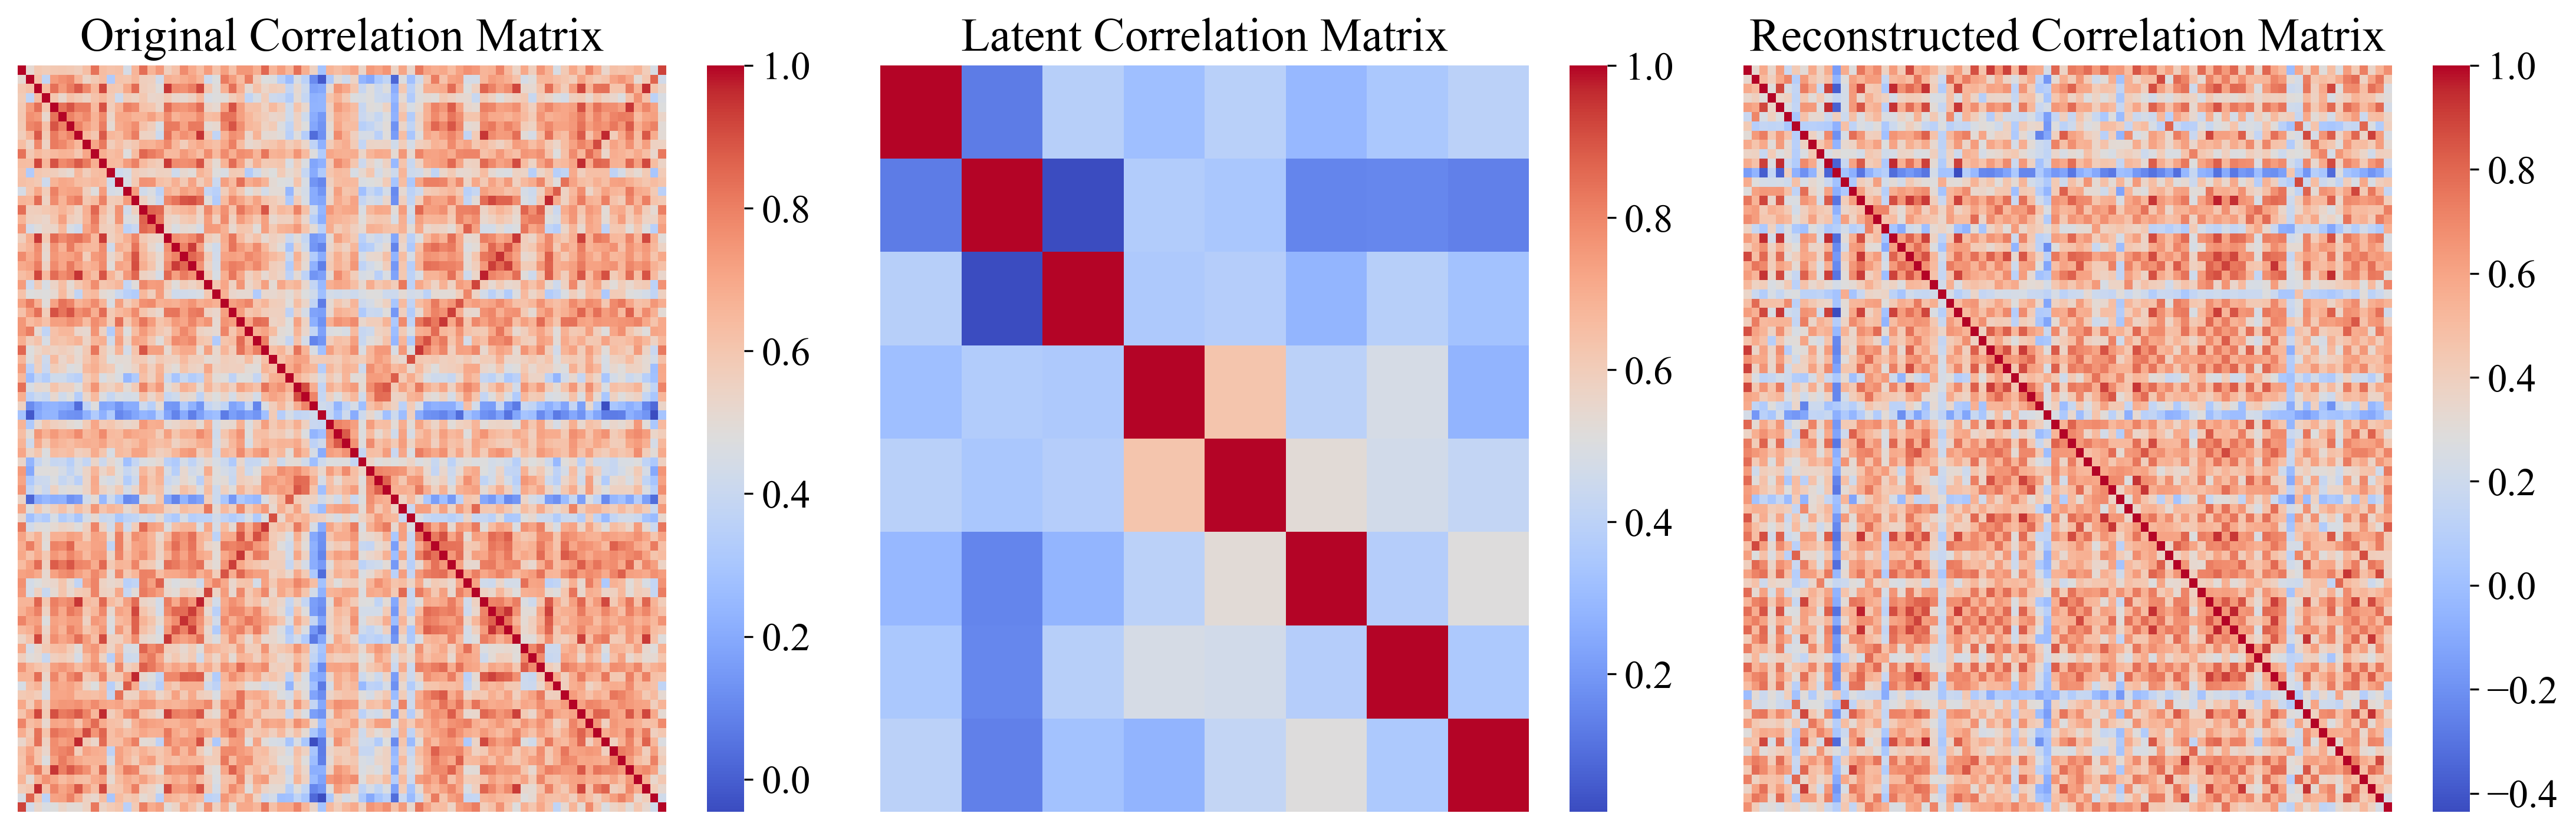

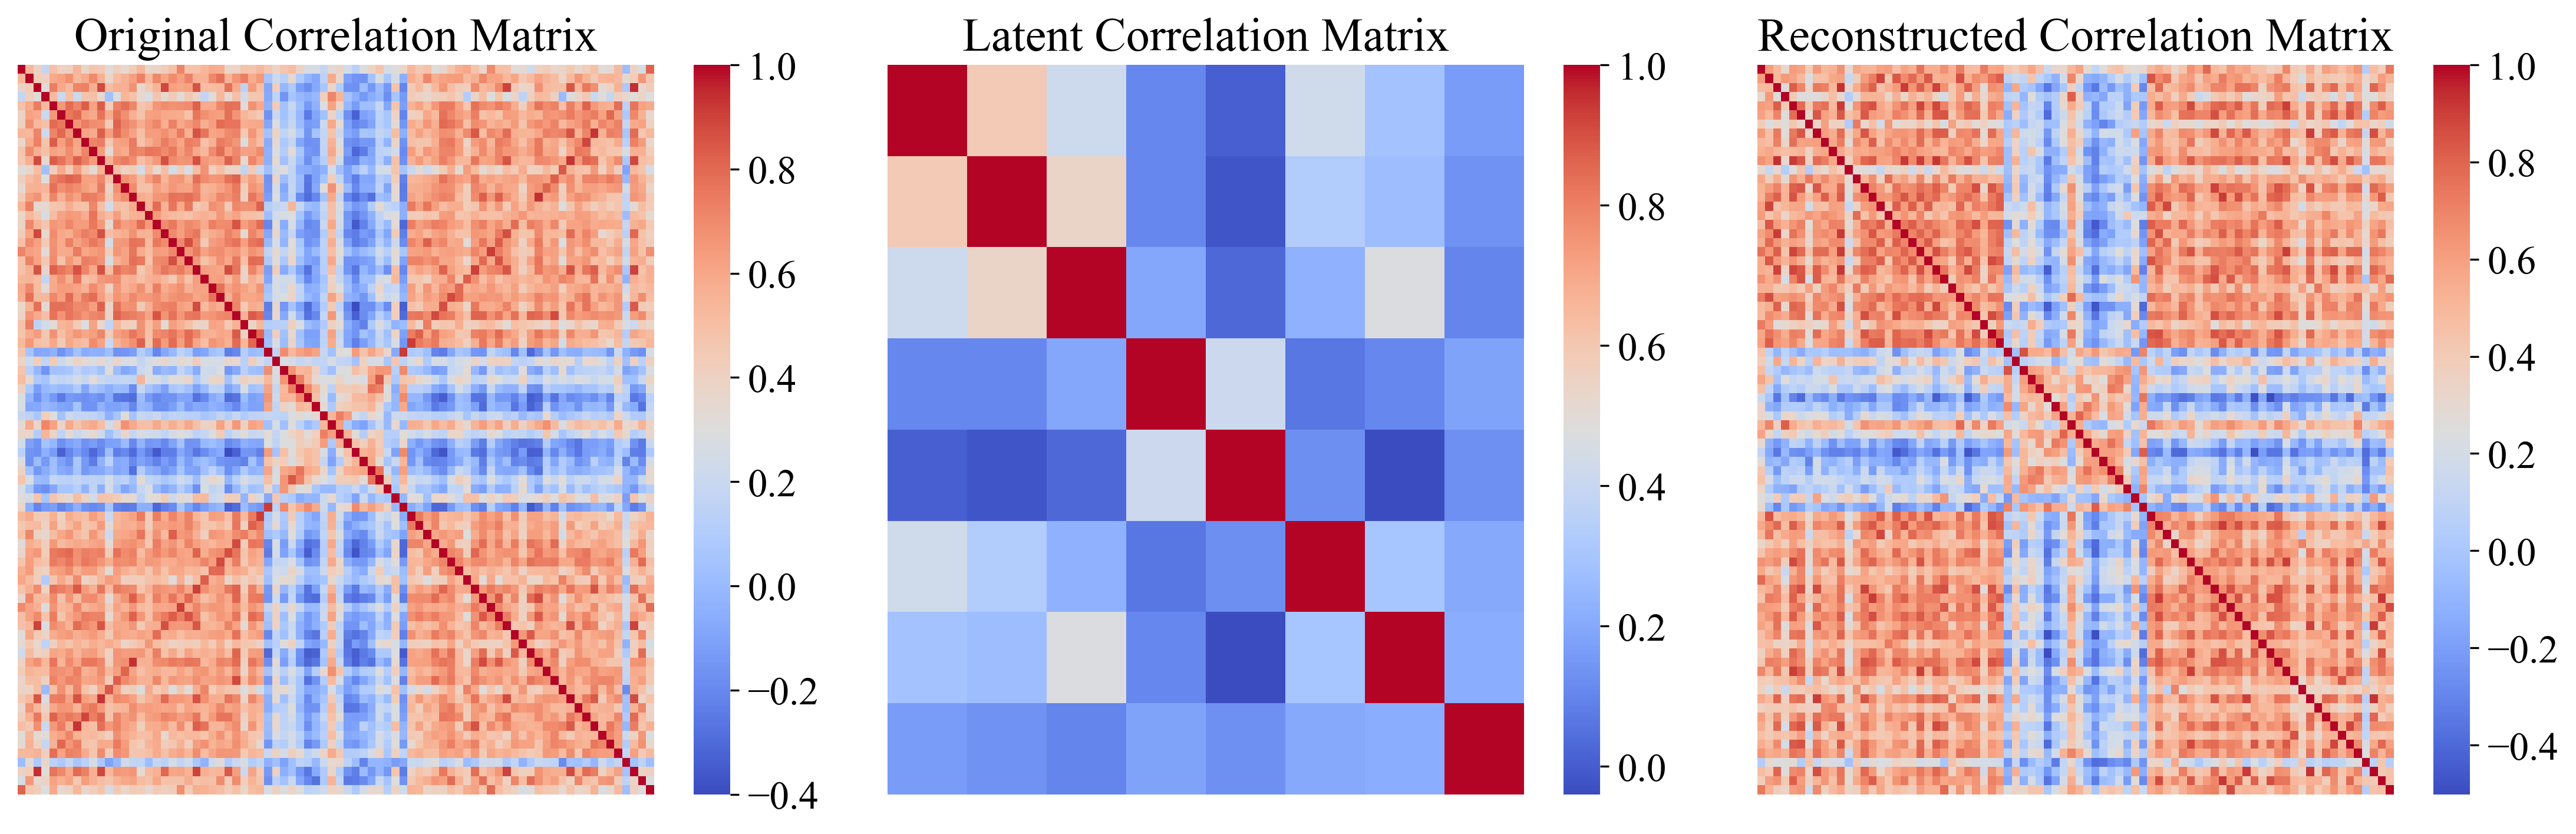

In [31]:
# Load the best model
latent_dim = 8
model = Autoencoder(latent_dim=latent_dim)
model.load_state_dict(torch.load(f'./models/pureMSE/AE_pureMSE_3840689408_lat{latent_dim}.pt'))
model.eval()

# Load and preprocess data
# Assuming 'concatenated_data' has been previously loaded and preprocessed
concatenated_data = concatenated_data
num_time_points = 200
num_brain_nodes = 80
num_participants = concatenated_data.shape[0] // num_time_points

# Reshape data
data_tensor = torch.tensor(concatenated_data, dtype=torch.float32)
data_tensor = data_tensor.reshape(num_participants, num_time_points, num_brain_nodes)

with torch.no_grad():
    outputs, latent = model(data_tensor.view(-1, num_brain_nodes))
    reconstructed_data = outputs.view(num_participants, num_time_points, num_brain_nodes)
    latent_data = latent.view(num_participants, num_time_points, latent_dim)

for i in range(15, 21):

    # Original Correlation Matrix
    participant_data = data_tensor[i]
    participant_data_tensor = participant_data.clone().detach()
    original_correlation_matrix = compute_fc_matrix_regular(participant_data_tensor)

    # Latent Correlation Matrix
    participant_latent_data = latent_data[i]
    participant_latent_data_tensor = participant_latent_data.clone().detach()
    latent_correlation_matrix = compute_fc_matrix_regular(participant_latent_data_tensor, num_brain_nodes=latent_dim)

    # Reconstructed Correlation Matrix
    participant_reconstructed_data = reconstructed_data[i]
    participant_reconstructed_data_tensor = participant_reconstructed_data.clone().detach()
    reconstructed_correlation_matrix = compute_fc_matrix_regular(participant_reconstructed_data_tensor)

    # Plot the matrices
    plt.figure(figsize=(15, 5))

    # Original Correlation Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(original_correlation_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    plt.title('Original Correlation Matrix')

    # Latent Correlation Matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(latent_correlation_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    plt.title('Latent Correlation Matrix')

    # Reconstructed Correlation Matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(reconstructed_correlation_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm')
    plt.title('Reconstructed Correlation Matrix')

    plt.tight_layout()
    plt.show()